# Predcition of Hospital Admission Related to Upper Respiratory Tract Infection

In this notebook, we develop Cox proportional hazard regression models to predict the risk of hospital admission related to upper respiratory tract infection (URTI).

In [1]:
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.preprocessing import OneHotEncoder
from datetime import date
from operator import attrgetter
import io
from contextlib import redirect_stdout
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

## 0- functions

In [2]:
# def create_lineplot(data, var, title, legend_title, ax1):
def create_lineplot(data, var, title, ax1):
    a = data.groupby(['date', var]).size().reset_index()
    a.columns = ['date', var, 'Freq']
    # a.Freq = a.Freq*1000
    a = a[a.Freq > 5]
    sns.lineplot(x='date', y='Freq', 
            hue=var, 
            data=a,
            ax=ax1)
    ax1.set_title(title)
    ax1.set_ylabel('Count')
    ax1.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=90)
#     ax1.legend(title=legend_title)
    # ax1.grid()
    ax1.axvline(x="2020-01", color='black', ls='--', lw=1.5)
    ax1.axvline(x="2020-04", color='black', ls='--', lw=1.5)
    ax1.axvline(x="2021-04", color='black', ls='--', lw=1.5)

In [3]:
# function to transform cph model summary and save it as html
def GetPrintSummary(model):
    output = ""
    with io.StringIO() as buf, redirect_stdout(buf):
        model.print_summary(style="html")
        output = buf.getvalue()
    return output

In [4]:
def round_five_mul(x, base=5):
    return base * round(x/base)

In [5]:
#function to process infection data 
def proc_infec_data(data, i):
    datum = data
    datum = datum[['age', 'age_cat', 'sex', 'flu_vaccine', 'smoking_status', 'bmi', 'imd', 'ethnicity', 
                   'region', 'CCI', 'died_date', 'deregistered_date', 'practice', 
                   'antibacterial_brit_'+str(i), 'urti_date_'+str(i), 'urti_ab_date_'+str(i), 'urti_ab_type_'+str(i),
                   'incdt_urti_date_'+str(i), 'admitted_urti_date_'+str(i), 'sgss_gp_cov_urti_date_'+str(i)]]
    
    #drop rows with no urti reord
    datum = datum[datum['urti_date_'+str(i)].notnull()]
    #exclusion of covid positive 90 days before and 30 days after dx with urti_i
    datum = datum[datum['sgss_gp_cov_urti_date_'+str(i)] == 0]
    #rename variables with i
    datum.rename(columns={'urti_date_'+str(i): 'urti_date', 'urti_ab_date_'+str(i): 'urti_ab_date', 
                           'urti_ab_type_'+str(i): 'ab_type', 'antibacterial_brit_'+str(i): 'antibacterial_brit',
                           'incdt_urti_date_'+str(i): 'incdt_urti_date', 'incdt_urti_type_'+str(i): 'incdt_urti_type',
                           'admitted_urti_date_'+str(i): 'admitted_urti_date',
                           'sgss_gp_cov_urti_date_'+str(i): 'sgss_gp_cov_urti_date'},
                inplace=True)
    
    return datum

In [6]:
def cox_data_prep(data, vars, vars_countinuous, vars_output):
    # data_req = data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit',
    #              'event_urti_admitted', 'duration_urti_admitted']]
    data_req = data[vars+vars_countinuous+vars_output]

    # encoding categorical data for CPH
    # data_enc = data_req[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit']].reset_index()
    data_enc = data_req[vars+vars_countinuous].reset_index()
    # data_enc

    # creating instance of one-hot-encoder
    enc = OneHotEncoder()
    results = enc.fit_transform(data_enc)
    data_req_enc = pd.DataFrame(enc.fit_transform(data_enc[vars]).toarray())
    data_req_enc.columns = enc.get_feature_names(data_enc[vars].columns)
    data_req_enc = data_enc[vars_countinuous].join(data_req_enc) 

    return data_req, data_req_enc

In [7]:
def make_summary_table(infection, infection_type, data):
    #summary table
    summary_table = data.sum(axis=0).reset_index()
    summary_table.columns = ['variable', 'count']
    #round count to make last digit either 0 or 5
    summary_table['mean'] = data.mean(axis=0).reset_index()[0]
    summary_table['count'] = round_five_mul(summary_table['count'], base=5)
    summary_table['std'] = data.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table.loc[(summary_table['count'] <= 5), 'count'] = 'SM'
    # summary_table

    # save table
    summary_table.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'.csv', index=False)

In [8]:
def make_summary_table_hosped(infection, infection_type, data):
    #keep hospitalised cses (events=1)
    data_hosped = data[data['event_'+infection+'_admitted'] == 1]

    # encoding categorical hosped data
    data_hosped = data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period', 'antibacterial_brit']].reset_index()
    # data_hosped

    # creating instance of one-hot-encoder
    enc = OneHotEncoder()
    results = enc.fit_transform(data_hosped)
    data_hosped_enc = pd.DataFrame(enc.fit_transform(data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period']]).toarray())
    data_hosped_enc.columns = enc.get_feature_names(data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period']].columns)
    data_hosped_enc = data_hosped[['antibacterial_brit']].join(data_hosped_enc)

    # data_hosped_enc#.head()
    #summary table for hosped cases
    summary_table_hosped = data_hosped_enc.sum(axis=0).reset_index()
    summary_table_hosped.columns = ['variable', 'count']
    summary_table_hosped['mean'] = data_hosped_enc.mean(axis=0).reset_index()[0]
    #round count to make last digit either 0 or 5
    summary_table_hosped['count'] = round_five_mul(summary_table_hosped['count'], base=5)
    summary_table_hosped['std'] = data_hosped_enc.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table_hosped.loc[(summary_table_hosped['count'] <= 5), 'count'] = 'SM'
    # summary_table_hosped

    # save table
    summary_table_hosped.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'_hosped.csv', index=False)

In [9]:
def cox_model_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #calculate and save ci
    ci = cph.concordance_index_
    a = open('../output/hospitalisation_prediction_'+infection+'/'+infection+'_'+infection_type+'_ci.txt', "w")
    a.write("")
    a.writelines(['Concordance index for '+infection+'_'+infection_type+' with development data: %.4f' % (ci)])

    return cph, data_train, data_test

In [10]:
def betas_sumbetas_calculate(cph, directory, betas_name, data_infection_enc, data_infection, sum_betas_name):

    # cleaning up covariates to make them compatible with the encoded data
    covariates = cph.params_.reset_index()#.hazard_ratios_
    covariates.covariate = covariates.covariate.str.replace("[","")
    covariates.covariate = covariates.covariate.str.replace("]","")
    covariates.covariate = covariates.covariate.str.replace("T.","_")
    # covariates.shape

    # save coefficients
    covariates.to_csv(directory+betas_name, index=False)

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv(directory+'hazard_ratios_'+betas_name, index=False)

    # transpose and sort covariates and coefficients
    covariatesT = covariates.T
    # covariatesT.covariate = covariates
    header = covariatesT.iloc[0]
    covariatesT = covariatesT[1:]
    covariatesT.columns = header
    covariatesT = covariatesT.sort_index(axis = 1) #sort covariates to match data
    # covariatesT.shape

    # further cleaning up covariates to make them compatible with the encoded data
    mylist = ["'" + item + "'" for item in covariates.covariate] #adds single quotation mark
    mylist = [value.replace("'", "") for value in mylist] #removes double quotation mark 

    #match mylist (covariates of cox model) with encoded data
    data = data_infection_enc[data_infection_enc.columns.intersection(mylist)] 
    data = data.sort_index(axis = 1) #sort 
    # data.shape

    # multiply betas and encoded data
    betas = data.multiply(np.array(covariatesT), axis='columns')
    # betas

    # sum up betas of each row to calculate sum of betas 
    sum_betas = betas.sum(axis=1)
    # sum_betas
#######################################################
    # predict cumulative hazard values at day 30 and match them with sum of betas
    sum_betas_hazard = cph.predict_cumulative_hazard(data_infection).loc[[30]].T.reset_index(drop=True)
    sum_betas_hazard['sum_betas'] = sum_betas
    # sum_betas_hazard

    #drop rows with predicted risks greater than 99th percentile of all risks
    sum_betas_hazard = sum_betas_hazard[sum_betas_hazard[30] <= sum_betas_hazard[30].quantile(0.99)]  
    # return sum_betas_hazard

    # sort values of sum of betas
    sum_betas_hazard = sum_betas_hazard.sort_values(by=['sum_betas'])
    # sum_betas_hazard

    # binning sum of betas into 100 bins
    sum_betas_hazard['bins'] = pd.cut(sum_betas_hazard['sum_betas'], 100) #100 intervals between min and max of sum_betas
    # sum_betas_hazard

    #calculate mean of cumulative hazar at day 30 by groupby 
    sum_betas_hazard_groupby = sum_betas_hazard.groupby(['bins'])[30.0].describe().reset_index()
    # sum_betas_hazard_groupby

    #calculate interpolation of missing mean values 
    sum_betas_hazard_groupby['mean_interpolate'] = sum_betas_hazard_groupby['mean'].interpolate(method='linear')

    # separate upper and lower boundries of bins
    sum_betas_hazard_groupby['bin_lower'] = sum_betas_hazard_groupby['bins'].map(attrgetter('left'))
    sum_betas_hazard_groupby['bin_upper'] = sum_betas_hazard_groupby['bins'].map(attrgetter('right'))
    # sum_betas_hazard_groupby.head()

    # select relevant columns including mean of cumulative hazard for each bin and the interpolation of means of cumulative hazard
    sum_betas = sum_betas_hazard_groupby[['bin_lower', 'bin_upper', 'mean_interpolate']]

    # save relevant columns of sum_betas
    sum_betas.to_csv(directory+sum_betas_name, index=False)

In [11]:
def cph_roc_curve(cph, event_col_name, data_train, data_test, directory, roc_name):
    # analysis of discrimination (training) by calculating cumulative hazard at day 30 and comparing it with variable event  
    cph_train_cumulative_hazard = cph.predict_cumulative_hazard(data_train)
    cph_train_cumulative_hazard = cph_train_cumulative_hazard.loc[[30]].T
    cph_train_cumulative_hazard[event_col_name] = data_train[event_col_name]
    cph_train_cumulative_hazard = cph_train_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)
    # cph_train_cumulative_hazard

    # analysis of discrimination (testing) by calculating cumulative hazard at day 30 and comparing it with variable event  
    cph_test_cumulative_hazard = cph.predict_cumulative_hazard(data_test)
    cph_test_cumulative_hazard = cph_test_cumulative_hazard.loc[[30]].T
    cph_test_cumulative_hazard[event_col_name] = data_test[event_col_name]
    cph_test_cumulative_hazard = cph_test_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)
    # cph_test_cumulative_hazard

    # plot roc curves
    r_fpr1, r_tpr1, _ = roc_curve(cph_train_cumulative_hazard[event_col_name], cph_train_cumulative_hazard.cumulative_hazard)
    r_fpr2, r_tpr2, _ = roc_curve(cph_test_cumulative_hazard[event_col_name], cph_test_cumulative_hazard.cumulative_hazard)

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line1, = plt.plot(r_fpr1, r_tpr1, linestyle='-', marker='o', markersize=6, markevery=0.1, color='black', label='Cox with development data')
    line2, = plt.plot(r_fpr2, r_tpr2, linestyle='--', marker='v', markersize=6, markevery=0.1, color='red', label='Cox with validation data')

    squares = [0,1.01]
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)

    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=14)
    # plt.title('', fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    # plt.tight_layout()
    plt.savefig(directory+'/'+roc_name, bbox_inches='tight')
    plt.show()

In [12]:
def cph_calibration(cph, data_train, event_name, data_test, directory, calib_train_name, calib_test_name):
    #predict cumulative hazard in day 30
    prob_pred_true_train = cph.predict_cumulative_hazard(data_train).loc[[30]].T
    prob_pred_true_train.columns = ['pred']
    # prob_pred_true_train

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_true_train['bins'] = pd.qcut(prob_pred_true_train['pred'], 10)
    # prob_pred_true_train

    #merge cumulative hazards with their actual events (0, 1)
    prob_pred_true_train = pd.merge(prob_pred_true_train, data_train[event_name], left_index=True, right_index=True)
    # prob_pred_true_train

    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    prob_pred_true_train_groupby_bin = prob_pred_true_train.groupby('bins')[['pred', event_name]].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_true_train_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']
    # prob_pred_true_train_groupby_bin

    #calculate proportion of events in each bin
    prob_pred_true_train_groupby_bin['event_proportion'] = prob_pred_true_train_groupby_bin['event_sum']/prob_pred_true_train_groupby_bin['event_count']
    # prob_pred_true_train_groupby_bin
############
    #predict cumulative hazard in day 30
    prob_pred_true_test = cph.predict_cumulative_hazard(data_test).loc[[30]].T #[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit', 'gp_count']]).loc[[30]].T#.reset_index(drop=True)
    prob_pred_true_test.columns = ['pred']

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_true_test['bins'] = pd.qcut(prob_pred_true_test['pred'], 10)

    #merge cumulative hazards with their actual events (0, 1)
    prob_pred_true_test = pd.merge(prob_pred_true_test, data_test[event_name], left_index=True, right_index=True)

    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    prob_pred_true_test_groupby_bin = prob_pred_true_test.groupby('bins')[['pred', event_name]].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_true_test_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

    #calculate proportion of events in each bin
    prob_pred_true_test_groupby_bin['event_proportion'] = prob_pred_true_test_groupby_bin['event_sum']/prob_pred_true_test_groupby_bin['event_count']
    # prob_pred_true_test_groupby_bin
###################
    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.scatter(prob_pred_true_train_groupby_bin.pred_mean, prob_pred_true_train_groupby_bin.event_proportion, marker='o', facecolors='none', edgecolors='g', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.ylim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    # plt.legend(['CPH calibration with training data', 'CPH calibration with testing data'], fontsize=14)
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.savefig(directory+calib_train_name, bbox_inches='tight')
    plt.show()

    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.scatter(prob_pred_true_test_groupby_bin.pred_mean, prob_pred_true_test_groupby_bin.event_proportion, marker='v', facecolors='none', edgecolors='y', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.ylim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    # plt.legend(['CPH calibration with training data', 'CPH calibration with testing data'], fontsize=14)
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.savefig(directory+calib_test_name, bbox_inches='tight')
    plt.show()

In [13]:
def cph_output(cph, infection, infection_type, data_train, data_test, event_name, duration_name, directory):
    # calculate concordance index, AUROC, and Brier score of cph model
    concord_index_train = concordance_index(data_train[duration_name], -cph.predict_partial_hazard(data_train), data_train[event_name])
    concord_index_test = concordance_index(data_test[duration_name], -cph.predict_partial_hazard(data_test), data_test[event_name])
    
    # save model outputs
    a = open(directory+'cph_'+infection+'_'+infection_type+'_output.txt', "w")
    a.write("")
    a.writelines(['Concordance index for '+infection+'_'+infection_type+' with development data: %.4f' % (concord_index_train), 
                '\nConcordance index for '+infection+'_'+infection_type+' with validation data: %.4f' % (concord_index_test)])

In [14]:
def cox_model_abs_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + urti_ab_date"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [15]:
def cox_model_ab_type_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + ab_type_cat"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [16]:
def cox_model_strat_sex_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + urti_ab_date"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [17]:
def cox_model_strat_age_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + urti_ab_date"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

## 1- data preparation

In [18]:
data = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_urti.csv.gz')

data.shape

(200000, 224)

In [19]:
# save model outputs
a = open("../output/hospitalisation_prediction_urti/data_urti_record_cph_urti.txt", "w")
a.write("")
a.writelines(['data_urti_1 #with a record, #with no record: %.0f' % (data['urti_date_1'].notna().sum()), ', %.0f' % (data['urti_date_1'].isna().sum()),
              '\ndata_urti_2 #with a record, #with no record: %.0f' % (data['urti_date_2'].notna().sum()), ', %.0f' % (data['urti_date_2'].isna().sum()),
              '\ndata_urti_3 #with a record, #with no record: %.0f' % (data['urti_date_3'].notna().sum()), ', %.0f' % (data['urti_date_3'].isna().sum()),
              '\ndata_urti_4 #with a record, #with no record: %.0f' % (data['urti_date_4'].notna().sum()), ', %.0f' % (data['urti_date_4'].isna().sum()),
              '\ndata_urti_5 #with a record, #with no record: %.0f' % (data['urti_date_5'].notna().sum()), ', %.0f' % (data['urti_date_5'].isna().sum()),
              '\ndata_urti_6 #with a record, #with no record: %.0f' % (data['urti_date_6'].notna().sum()), ', %.0f' % (data['urti_date_6'].isna().sum()),
              '\ndata_urti_7 #with a record, #with no record: %.0f' % (data['urti_date_7'].notna().sum()), ', %.0f' % (data['urti_date_7'].isna().sum()),
              '\ndata_urti_8 #with a record, #with no record: %.0f' % (data['urti_date_8'].notna().sum()), ', %.0f' % (data['urti_date_8'].isna().sum()),
              '\ndata_urti_9 #with a record, #with no record: %.0f' % (data['urti_date_9'].notna().sum()), ', %.0f' % (data['urti_date_9'].isna().sum()),
              '\ndata_urti_10 #with a record, #with no record: %.0f' % (data['urti_date_10'].notna().sum()), ', %.0f' % (data['urti_date_10'].isna().sum()),
              '\ndata_urti_11 #with a record, #with no record: %.0f' % (data['urti_date_11'].notna().sum()), ', %.0f' % (data['urti_date_11'].isna().sum()),
              '\ndata_urti_12 #with a record, #with no record: %.0f' % (data['urti_date_12'].notna().sum()), ', %.0f' % (data['urti_date_12'].isna().sum()),
              '\ndata_urti_13 #with a record, #with no record: %.0f' % (data['urti_date_13'].notna().sum()), ', %.0f' % (data['urti_date_13'].isna().sum()),
              '\ndata_urti_14 #with a record, #with no record: %.0f' % (data['urti_date_14'].notna().sum()), ', %.0f' % (data['urti_date_14'].isna().sum()),
              '\ndata_urti_15 #with a record, #with no record: %.0f' % (data['urti_date_15'].notna().sum()), ', %.0f' % (data['urti_date_15'].isna().sum()),
              '\ndata_urti_16 #with a record, #with no record: %.0f' % (data['urti_date_16'].notna().sum()), ', %.0f' % (data['urti_date_16'].isna().sum()),
              '\ndata_urti_17 #with a record, #with no record: %.0f' % (data['urti_date_17'].notna().sum()), ', %.0f' % (data['urti_date_17'].isna().sum()),
              '\ndata_urti_18 #with a record, #with no record: %.0f' % (data['urti_date_18'].notna().sum()), ', %.0f' % (data['urti_date_18'].isna().sum()),
              '\ndata_urti_19 #with a record, #with no record: %.0f' % (data['urti_date_19'].notna().sum()), ', %.0f' % (data['urti_date_19'].isna().sum()),
              '\ndata_urti_20 #with a record, #with no record: %.0f' % (data['urti_date_20'].notna().sum()), ', %.0f' % (data['urti_date_20'].isna().sum()),
              ])

### 1-2- additional variables
Calculating Charlson Comorbidity Index based on https://www.nature.com/articles/4500889.pdf?origin=ppub

In [20]:
data['CCI'] = np.nan
col0 = data.columns.get_loc('CCI')

col1 = data.columns.get_loc('cancer_comor')
col2 = data.columns.get_loc('cardiovascular_comor')
col3 = data.columns.get_loc('chronic_obstructive_pulmonary_comor') ##
col4 = data.columns.get_loc('heart_failure_comor') ##
col5 = data.columns.get_loc('connective_tissue_comor')
col6 = data.columns.get_loc('dementia_comor')
col7 = data.columns.get_loc('diabetes_comor')
col8 = data.columns.get_loc('diabetes_complications_comor')
col9 = data.columns.get_loc('hemiplegia_comor')
col10 = data.columns.get_loc('hiv_comor')
col11 = data.columns.get_loc('metastatic_cancer_comor')
col12 = data.columns.get_loc('mild_liver_comor')
col13 = data.columns.get_loc('mod_severe_liver_comor')
col14 = data.columns.get_loc('mod_severe_renal_comor')
col15 = data.columns.get_loc('mi_comor')
col16 = data.columns.get_loc('peptic_ulcer_comor')
col17 = data.columns.get_loc('peripheral_vascular_comor')


for idx, x in enumerate(data['CCI']):
    n=0
    if data.iat[idx, col15] == 1: # mi_comor
        n=n+1
    if data.iat[idx, col2] == 1: # cardiovascular_comor
        n=n+1 
    if data.iat[idx, col17] == 1: # peripheral_vascular_comor
        n=n+1 
    if data.iat[idx, col3] == 1: # chronic_obstructive_pulmonary_comor
        n=n+1
    if data.iat[idx, col7] == 1: # diabetes_comor
        n=n+1
    if data.iat[idx, col6] == 1: # dementia_comor
        n=n+1
    if data.iat[idx, col16] == 1: # peptic_ulcer_comor
        n=n+1
    if data.iat[idx, col5] == 1: # connective_tissue_comor
        n=n+1
    if data.iat[idx, col12] == 1: # mild_liver_comor
        n=n+1
    if data.iat[idx, col9] == 1: # hemiplegia_comor
        n=n+2
    if data.iat[idx, col14] == 1: # mod_severe_renal_comor
        n=n+2
    if data.iat[idx, col8] == 1: # diabetes_complications_comor
        n=n+2
    if data.iat[idx, col1] == 1: # cancer_comor
        n=n+2
    if data.iat[idx, col13] == 1: # mod_severe_liver_comor
        n=n+3
    if data.iat[idx, col11] == 1: # metastatic_cancer_comor
        n=n+6
    if data.iat[idx, col10] == 1: # hiv_comor
        n=n+6
    
    data.iat[idx, col0]=n

data.CCI.value_counts()

0.0     37177
1.0     37100
2.0     32753
3.0     24898
4.0     14980
6.0     12289
7.0      9833
5.0      8441
8.0      7918
9.0      5726
10.0     3380
11.0     1865
12.0     1407
13.0      878
14.0      581
15.0      370
16.0      193
17.0      117
18.0       51
19.0       26
20.0       12
21.0        4
22.0        1
Name: CCI, dtype: int64

## 2- data preparation
This includes data type conversion and exclusion of cases that are not considered in the infection-related hospital admission, i.e. those who were diagnosed with Covid19 three months (=90 days) before and one month (=30 days) after hospital admission.

### 2-1- gathering data

In [21]:
#read 12 urtis and concatenate them 
data_urti_1 = proc_infec_data(data,1)
data_urti_2 = proc_infec_data(data,2)
data_urti_3 = proc_infec_data(data,3)
data_urti_4 = proc_infec_data(data,4)
data_urti_5 = proc_infec_data(data,5)
data_urti_6 = proc_infec_data(data,6)
data_urti_7 = proc_infec_data(data,7)
data_urti_8 = proc_infec_data(data,8)
data_urti_9 = proc_infec_data(data,9)
data_urti_10 = proc_infec_data(data,10)
data_urti_11 = proc_infec_data(data,11)
data_urti_12 = proc_infec_data(data,12)
data_urti_13 = proc_infec_data(data,13)
data_urti_14 = proc_infec_data(data,14)
data_urti_15 = proc_infec_data(data,15)
data_urti_16 = proc_infec_data(data,16)
data_urti_17 = proc_infec_data(data,17)
data_urti_18 = proc_infec_data(data,18)
data_urti_19 = proc_infec_data(data,19)
data_urti_20 = proc_infec_data(data,20)

data_urti = pd.concat([data_urti_1, data_urti_2, data_urti_3, data_urti_4, data_urti_5, data_urti_6, data_urti_7, data_urti_8, data_urti_9, data_urti_10, data_urti_11, data_urti_12, data_urti_13, data_urti_14, data_urti_15, data_urti_16, data_urti_17, data_urti_18, data_urti_19, data_urti_20])
data_urti.reset_index(inplace=True, drop=True)
data_urti.shape

(360257, 20)

### 2-2- add season, event, and duration variables
#### season

In [22]:
# convert data types
data_urti['urti_date'] = data_urti['urti_date'].astype('datetime64[ns]')
data_urti['admitted_urti_date'] = data_urti['admitted_urti_date'].astype('datetime64[ns]')
data_urti.died_date = data_urti.died_date.astype('datetime64[ns]')
data_urti.deregistered_date = data_urti.deregistered_date.astype('datetime64[ns]')

#add a variable called date using gp consultation dates
data_urti['date'] = data_urti['urti_date'] #gp_cons_urti
data_urti['date'] = data_urti['date'].dt.strftime('%Y-%m')
print(f'min date: {data_urti.date.min()}')
print(f'max date: {data_urti.date.max()}')
print(f'length of data_urti: {len(data_urti)}')

min date: 2019-01
max date: 2022-11
length of data_urti: 360257


In [23]:
#get today's date in year and month
today_date_y_m = date.today()
today_date_y_m = today_date_y_m.strftime('%Y-%m')
# today_date_y_m

#drop any records of data_urti with today's date in year and month
data_urti = data_urti[data_urti['date'] != today_date_y_m]

#get two months before today's date in year and month 
last_1_month_date_y_m = date.today() - pd.DateOffset(months=1)
last_1_month_date_y_m = last_1_month_date_y_m.strftime('%Y-%m')
last_2_month_date_y_m = date.today() - pd.DateOffset(months=2)
last_2_month_date_y_m = last_2_month_date_y_m.strftime('%Y-%m')
#drop any record of data with two month before today's date in year and month
data_urti = data_urti[data_urti['date'] != last_1_month_date_y_m]
data_urti = data_urti[data_urti['date'] != last_2_month_date_y_m]

#add a variable called season based on the month of urti records
data_urti['season'] = np.nan
data_urti['date_month'] = pd.DatetimeIndex(data_urti['date']).month

conditions = [
    (data_urti['date_month'] >= 3) & (data_urti['date_month'] <= 5),
    (data_urti['date_month'] >= 6) & (data_urti['date_month'] <= 8),
    (data_urti['date_month'] >= 9) & (data_urti['date_month'] <= 11),]
choices = ['spring', 'summer', 'autumn']
data_urti['season'] = np.select(conditions, choices, default='winter')

print(data_urti['season'].value_counts())
print(f'\nmin date: {data_urti.date.min()}')
print(f'max date: {data_urti.date.max()}')
print(f'length: {len(data_urti)}')

summer    93749
spring    93702
winter    83766
autumn    69533
Name: season, dtype: int64

min date: 2019-01
max date: 2022-08
length: 340750


In [24]:
# data_urti = data_urti[data_urti['date'] <= '2019-12']
# data_urti = data_urti[(data_urti['date'] >= '2020-03') & (data_urti['date']<= '2021-03')]
# data_urti = data_urti[data_urti['date'] >= '2021-04']
# print(f'min date: {data_urti.date.min()}')
# print(f'max date: {data_urti.date.max()}')

In [ ]:
#add period variable
data_urti.loc[(data_urti['date'] <= '2019-12'), 'period'] = 'prepandemic'
data_urti.loc[((data_urti['date'] >= '2020-01') & (data_urti['date'] <= '2021-03')), 'period'] = 'during_pandemic'
data_urti.loc[(data_urti['date'] >= '2021-04'), 'period'] = 'post_2nd_lockdown'

#### event and duration

In [25]:
#scenario 1
#not hosped (nothing happened)
#data_urti = data_urti[data_urti['admitted_urti_date'].notnull()]
data_urti.loc[data_urti['admitted_urti_date'].isnull(), 'event_urti_admitted'] = 0
data_urti['event_urti_admitted'].value_counts()

0.0    238268
Name: event_urti_admitted, dtype: int64

In [26]:
#scenario 2 
# become a case (uncensoring)
#calculating days between infection gp consultation and hosp
# data_urti['delta_urti_admitted'] = (data_urti['admitted_urti_date'] - data_urti['urti_date']).dt.days
data_urti['delta_urti_admitted'] = (data_urti['admitted_urti_date'] - data_urti['urti_date']).dt.days #gp_cons_urti
data_urti.loc[((data_urti['delta_urti_admitted'] >= 0) & (data_urti['delta_urti_admitted'] <= 30)), 'event_urti_admitted'] = 1
# data_urti['event_urti_admitted'].value_counts()

#scenario 2
#drop whoever was admitted before urti consultation, i.e. negative value for delta_urti_admitted
data_urti = data_urti[~(data_urti['delta_urti_admitted'] < 0)]
data_urti['delta_urti_admitted'].value_counts()

2.0       97
96.0      95
93.0      95
20.0      93
43.0      91
          ..
1343.0     1
1352.0     1
1400.0     1
1390.0     1
1341.0     1
Name: delta_urti_admitted, Length: 1400, dtype: int64

In [27]:
#scenario 3
#censor died patients
data_urti['delta_admitted_died'] = (data_urti['died_date'] - data_urti['admitted_urti_date']).dt.days
data_urti.loc[data_urti['delta_admitted_died'] < 0, 'delta_admitted_died'] = np.NaN
# data_urti.loc[data_urti['delta_admitted_died'] >= 0, 'event_urti_admitted'] = 0
data_urti.loc[((data_urti['delta_admitted_died'] >= 0) & (data_urti['delta_admitted_died'] <= 30)), 'event_urti_admitted'] = 0
# data_urti['event_urti_admitted'].value_counts()

#scenario 3
#censor deregistered patients
data_urti['delta_admitted_deregistered'] = (data_urti['deregistered_date'] - data_urti['admitted_urti_date']).dt.days
data_urti.loc[data_urti['delta_admitted_deregistered'] < 0, 'delta_admitted_deregistered'] = np.NaN
# data_urti.loc[data_urti['delta_admitted_deregistered'] >= 0, 'event_urti_admitted'] = 0
data_urti.loc[((data_urti['delta_admitted_deregistered'] > 0) & (data_urti['delta_admitted_deregistered'] <= 30)), 'event_urti_admitted'] = 0
# data_urti['event_urti_admitted'].value_counts()

#agg scenario 3s
data_urti['delta_admitted_died_deregistered'] = data_urti['delta_admitted_deregistered'].combine_first(data_urti['delta_admitted_died'])
data_urti.loc[data_urti['delta_admitted_died_deregistered'] < 0, 'delta_admitted_died_deregistered'] = np.NaN
data_urti['delta_admitted_died_deregistered'].isnull().sum()#.value_counts()

287317

In [28]:
#scenario 1
#any other patients (nothing happened)
data_urti['event_urti_admitted'] = data_urti['event_urti_admitted'].replace(np.NaN, 0)
data_urti['event_urti_admitted'].value_counts()

0.0    290329
1.0      2277
Name: event_urti_admitted, dtype: int64

In [29]:
#assign values for duration column
data_urti['duration_urti_admitted'] = data_urti['delta_urti_admitted'].combine_first(data_urti['delta_admitted_died_deregistered'])
data_urti['duration_urti_admitted'] = data_urti['duration_urti_admitted'].replace(np.NaN, 30)
data_urti.loc[(data_urti['duration_urti_admitted'] > 30), 'duration_urti_admitted'] = 30
data_urti['duration_urti_admitted'].value_counts()

30.0    290392
2.0         97
20.0        93
0.0         90
28.0        88
24.0        85
12.0        81
29.0        81
16.0        79
22.0        79
15.0        78
11.0        77
25.0        77
23.0        77
9.0         76
6.0         75
8.0         73
5.0         73
1.0         72
18.0        71
4.0         71
21.0        71
14.0        70
26.0        69
19.0        63
27.0        63
10.0        62
13.0        60
7.0         58
3.0         53
17.0        52
Name: duration_urti_admitted, dtype: int64

In [30]:
# give value 1 to event_urti_admitted if duration_urti_admitted is greater or equal to 0 and less than 30
data_urti.loc[((data_urti['duration_urti_admitted'] >= 0) & (data_urti['duration_urti_admitted'] < 30)), 'event_urti_admitted'] = 1
data_urti['event_urti_admitted'].value_counts()

0.0    290326
1.0      2280
Name: event_urti_admitted, dtype: int64

In [31]:
#drop any rows with value 0 in duration column
data_urti = data_urti[~(data_urti['duration_urti_admitted'] == 0)]

#scenario2 (uncensoring) again to prevent conflict with other scenarios
data_urti.loc[((data_urti['delta_urti_admitted'] > 0) & (data_urti['delta_urti_admitted'] < 30)), 'event_urti_admitted'] = 1

In [32]:
# data_urti[data_urti['duration_urti_admitted']==0][['delta_urti_admitted', 'urti_date', 'gp_cons_urti', 'admitted_urti_date', 'delta_urti_admitted', 'delta_admitted_died_deregistered', 'event_urti_admitted', 'duration_urti_admitted']]
# data_urti.loc[151:200, ['event_urti_admitted', 'duration_urti_admitted']]
# data_urti.loc[201:250, ['event_urti_admitted', 'duration_urti_admitted']].sort_values(by=['duration_urti_admitted'])
data_urti[['event_urti_admitted', 'duration_urti_admitted']].sort_values(by=['duration_urti_admitted'])

,event_urti_admitted,duration_urti_admitted
306295,1.0,1.0
148581,1.0,1.0
32325,1.0,1.0
274978,1.0,1.0
270234,1.0,1.0
...,...,...
120599,0.0,30.0
120598,0.0,30.0
120597,0.0,30.0
120603,0.0,30.0


### 2-3- dealing with uninteresting and missing values

In [33]:
# prep before plot
data_urti['age'][data_urti['age'] < 0] = np.nan
data_urti = data_urti[data_urti['age_cat'] != '0-4']
data_urti = data_urti[data_urti['age_cat'] != '5-14']
# drop anybody with age less than 18
data_urti = data_urti[~(data_urti['age'] < 18)]  
print(f'Min age: {data_urti.age.min()}')

## remove died cases
#data_urti.died_date.value_counts()

# assign 0 (missingness) to all bmi values less than 10
data_urti['bmi'][data_urti['bmi'] < 10] = 0
# replace 0s with nans
data_urti['bmi'] = data_urti['bmi'].replace({0:np.nan})

# remove cases with negative antibacterial_brit
data_urti['antibacterial_brit'][data_urti['antibacterial_brit'] < 0] = np.nan

Min age: 18


In [34]:
dict_sex = {'F': 0, 'M': 1}
dict_smoking = {'S': 1, 'E': 2, 'N':3, 'M':np.nan}

data_urti = data_urti.replace({"sex": dict_sex})
# data_bmi = data_bmi.replace({"sex": dict_sex})
data_urti = data_urti.replace({"smoking_status": dict_smoking})

In [35]:
if ('region' in data_urti.columns) and (data_urti['region'].isnull().sum() > 0):
    # drop region value missing
    # data_urti['region_imp'] = data_urti['region']
    print(f'Cound of missing values in variable region before dropping rows with possible missing values: {data_urti.region.isnull().sum()}')
    data_urti = data_urti[data_urti['region'].notna()]

print(f'Cound of missing values in variable region: {data_urti.region.isnull().sum()}')
print(f'Count of categories of variable region: \n{data_urti.region.value_counts()}')

Cound of missing values in variable region: 0
Count of categories of variable region: 
London                      35308
East Midlands               17989
South West                  17938
West Midlands               17906
South East                  17884
Yorkshire and The Humber    17805
East                        17715
North East                  17711
North West                  17555
Name: region, dtype: int64


In [36]:
if ('antibacterial_brit' in data_urti.columns) and (data_urti['antibacterial_brit'].isnull().sum() > 0):
    print(f'Cound of missing values in variable antibacterial_brit before changing NANs to zeros: {data_urti.antibacterial_brit.isnull().sum()}')
    print(f'Mean of antibacterial_brit values before changing NAN to zeros: {data_urti.antibacterial_brit.mean():.3f}')
    data_urti['antibacterial_brit'] = data_urti['antibacterial_brit'].fillna(0)
    # data_urti['antibacterial_brit'] = data_urti['antibacterial_brit'].replace({'0':np.nan, 0:np.nan})

print(f'\nCound of missing values in variable antibacterial_brit after changing NANs to zeros: {data_urti.antibacterial_brit.isnull().sum()}')
print(f'Mean of antibacterial_brit values after changing NANs to zeros: {data_urti.antibacterial_brit.mean():.3f}')

Cound of missing values in variable antibacterial_brit before changing NANs to zeros: 3
Mean of antibacterial_brit values before changing NAN to zeros: 1.243

Cound of missing values in variable antibacterial_brit after changing NANs to zeros: 0
Mean of antibacterial_brit values after changing NANs to zeros: 1.243


In [37]:
if ('ethnicity' in data_urti.columns) and (data_urti['ethnicity'].isnull().sum() > 0):
    print(f'Count of missing values in variable ethnicity before changing them to Unknown category: {data_urti.ethnicity.isnull().sum()}')
    print(f'Count of categories of variable ethnicity before changing them to Unknown category: \n{data_urti.ethnicity.value_counts()}')
    # data_urti['ethnicity'] = data_urti['ethnicity'].astype(str)
    data_urti['ethnicity'] = data_urti['ethnicity'].fillna(0)

print(f'\nCound of missing values in variable ethnicity after changing NANs to Unknown category: {data_urti.ethnicity.isnull().sum()}')
print(f'Count of categories of variable ethnicity after changing NANs to Unknown category: \n{data_urti.ethnicity.value_counts()}')

Count of missing values in variable ethnicity before changing them to Unknown category: 44491
Count of categories of variable ethnicity before changing them to Unknown category: 
1.0    106943
5.0     13261
3.0     13116
Name: ethnicity, dtype: int64

Cound of missing values in variable ethnicity after changing NANs to Unknown category: 0
Count of categories of variable ethnicity after changing NANs to Unknown category: 
1.0    106943
0.0     44491
5.0     13261
3.0     13116
Name: ethnicity, dtype: int64


In [38]:
if ('smoking_status' in data_urti.columns) and (data_urti['smoking_status'].isnull().sum() > 0):
    print(f'Count of missing values in variable smoking_status before changing them to Unknown category: {data_urti.smoking_status.isnull().sum()}')
    print(f'Count of categories of variable smoking_status before changing them to Unknown category: \n{data_urti.smoking_status.value_counts()}')
    # data_urti['smoking_status'] = data_urti['smoking_status'].astype(str)
    data_urti['smoking_status'] = data_urti['smoking_status'].fillna(0)

print(f'\nCound of missing values in variable smoking_status after changing NANs to Unknown category: {data_urti.smoking_status.isnull().sum()}')
print(f'Count of categories of variable smoking_status after changing NANs to Unknown category: \n{data_urti.smoking_status.value_counts()}')

Count of missing values in variable smoking_status before changing them to Unknown category: 73246
Count of categories of variable smoking_status before changing them to Unknown category: 
1.0    69733
3.0    23234
2.0    11598
Name: smoking_status, dtype: int64

Cound of missing values in variable smoking_status after changing NANs to Unknown category: 0
Count of categories of variable smoking_status after changing NANs to Unknown category: 
0.0    73246
1.0    69733
3.0    23234
2.0    11598
Name: smoking_status, dtype: int64


In [39]:
if ('imd' in data_urti.columns) and (data_urti['imd'].isnull().sum() > 0):
    print(f'Count of missing values in variable imd before changing them to Unknown category: {data_urti.imd.isnull().sum()}')
    print(f'Count of categories of variable imd before changing them to Unknown category: \n{data_urti.imd.value_counts()}')
    # data_urti['imd'] = data_urti['imd'].astype(str)
    data_urti['imd'] = data_urti['imd'].fillna(0)

print(f'\nCound of missing values in variable imd after changing NANs to Unknown category: {data_urti.imd.isnull().sum()}')
print(f'Count of categories of variable imd after changing NANs to Unknown category: \n{data_urti.imd.value_counts()}')


Cound of missing values in variable imd after changing NANs to Unknown category: 0
Count of categories of variable imd after changing NANs to Unknown category: 
2    33972
3    33799
5    33733
1    33625
4    33572
0     9110
Name: imd, dtype: int64


In [40]:
data_urti['bmi_cat'] = 5
col_bmi_cat = data_urti.columns.get_loc('bmi_cat')

col_sex = data_urti.columns.get_loc('sex')
col_age = data_urti.columns.get_loc('age')
col_bmi = data_urti.columns.get_loc('bmi')

for idx, x in enumerate(data_urti['bmi_cat']):
    if data_urti.iat[idx, col_bmi] >= 30:
        data_urti.iat[idx, col_bmi_cat] = 1 #'Obese'
    if (data_urti.iat[idx, col_bmi] >= 25) and (data_urti.iat[idx, col_bmi] < 30):
        data_urti.iat[idx, col_bmi_cat] = 2 #'Overweight'
    if (data_urti.iat[idx, col_bmi] >= 18.5) and (data_urti.iat[idx, col_bmi] < 25):
        data_urti.iat[idx, col_bmi_cat] = 3 #'Healthy weight'
    if data_urti.iat[idx, col_bmi] < 18.5:
        data_urti.iat[idx, col_bmi_cat] = 4 #'Underweight'

data_urti['bmi_cat'].value_counts()

1    92347
5    45324
2    20043
3    14372
4     5725
Name: bmi_cat, dtype: int64

In [41]:
if ('bmi_cat' in data_urti.columns) and (data_urti['bmi_cat'].isnull().sum() > 0):
    print(f'Count of missing values in variable bmi_cat before changing them to Unknown category: {data_urti.bmi_cat.isnull().sum()}')
    print(f'Count of categories of variable bmi_cat before changing them to Unknown category: \n{data_urti.bmi_cat.value_counts()}')
    # data_urti['bmi_cat'] = data_urti['bmi_cat'].astype(str)
    data_urti['bmi_cat'] = data_urti['bmi_cat'].fillna(0)

print(f'\nCound of missing values in variable bmi_cat after changing NANs to Unknown category: {data_urti.bmi_cat.isnull().sum()}')
print(f'Count of categories of variable bmi_cat after changing NANs to Unknown category: \n{data_urti.bmi_cat.value_counts()}')


Cound of missing values in variable bmi_cat after changing NANs to Unknown category: 0
Count of categories of variable bmi_cat after changing NANs to Unknown category: 
1    92347
5    45324
2    20043
3    14372
4     5725
Name: bmi_cat, dtype: int64


In [42]:
#add variable ab_type_cat
#find ab types
ab_series = pd.value_counts(data_urti.ab_type)
#take percentages of ab categories
ab_category_perc = ab_series/ab_series.sum() * 100
#take first 2 categories of abs
mask = (ab_category_perc).lt(ab_category_perc[1])
#replace category other with categories with 4th percentage or more (less frequent abs)
data_urti['ab_type_cat'] = np.where(data_urti['ab_type'].isin(ab_series[mask].index),'other',data_urti['ab_type'])

#assign no to non ab users
data_urti.loc[data_urti['urti_ab_date'].isnull(), 'ab_type_cat'] = 'no'

#fill nas with 0 and then assign other to 0s
data_urti['ab_type_cat'] = data_urti['ab_type_cat'].fillna(0)
data_urti['ab_type_cat'].value_counts()

no             160306
0               14077
other            2020
Amoxicillin      1071
Doxycycline       337
Name: ab_type_cat, dtype: int64

### 2-4- translate values of categorical variables

In [43]:
# define dictionaries
dict_sex = {0: 'female', 1: 'male'}
dict_ethnicity = {1.0: 'white', 2.0: 'non-white', 3.0: 'non-white', 4.0: 'non-white', 5.0: 'non-white', 0: 'unknown'}
dict_smoking = {1.0:'smoker', 2.0:'ex_smoker', 3.0:'never_smoked', 0: 'unknown'}
dict_imd = {1:'very_affluent', 2:'affluent', 3:'medium', 4:'unaffluent', 5:'very_unaffluent', 0:'unknown'}
dict_bmi = {1:'obese', 2:'overweight', 3:'healthy_weight', 4:'underweight', 5:'unknown', 0:'unknown'}
dict_flu = {0: 'no', 1: 'yes'}
dict_region = {'London': 'london', 'North East': 'north_east', 'North West': 'north_west', 'East': 'east', 'West Midlands': 'west_midlands', 'Yorkshire and The Humber': 'yorkshire', 'South East': 'south_east', 'East Midlands': 'east_midlands', 'South West': 'south_west'}
dict_age = {'0-4':'0_4', '5-14':'5_14', '15-24':'15_24', '25-34':'25_34', '35-44':'35_44', '45-54':'45_54', '55-64':'55_64', '65-74':'65_74', '75+':'75_more'}
dict_ab_type = {0:'other'}

In [44]:
# reoplace values of dictionaries with existing ones
data_urti = data_urti.replace({"sex": dict_sex})
data_urti = data_urti.replace({"ethnicity": dict_ethnicity})
data_urti = data_urti.replace({"smoking_status": dict_smoking})
data_urti = data_urti.replace({"imd": dict_imd})
data_urti = data_urti.replace({"bmi_cat": dict_bmi})
data_urti = data_urti.replace({"flu_vaccine": dict_flu})
data_urti = data_urti.replace({"region": dict_region})
data_urti = data_urti.replace({"age_cat": dict_age})
data_urti = data_urti.replace({"ab_type_cat": dict_ab_type})
data_urti['ab_type_cat'].value_counts()

no             160306
other           16097
Amoxicillin      1071
Doxycycline       337
Name: ab_type_cat, dtype: int64

### 2-5- categorising and assigning max value for continuous variables

In [45]:
# categorising
data_urti['CCI_cat'] = pd.cut(data_urti['CCI'], right=False, bins=[0,1,3,5,7,10000000000], labels=['very_low', 'low', 'medium', 'high', 'very_high'])
data_urti['CCI_cat'].value_counts()

low          61983
medium       36252
very_low     32725
very_high    28773
high         18078
Name: CCI_cat, dtype: int64

In [46]:
# assign max value to outliers (beyond 95 percentile)
data_urti['antibacterial_brit'].clip(0, data_urti['antibacterial_brit'].quantile(0.95), inplace=True)
data_urti['antibacterial_brit'].max()

data_urti['antibacterial_brit_cat'] = pd.cut(data_urti['antibacterial_brit'], 3, labels=['low', 'medium', 'high'])
data_urti['antibacterial_brit_cat'].value_counts()

low       103513
high       44308
medium     29990
Name: antibacterial_brit_cat, dtype: int64

## 3- plots

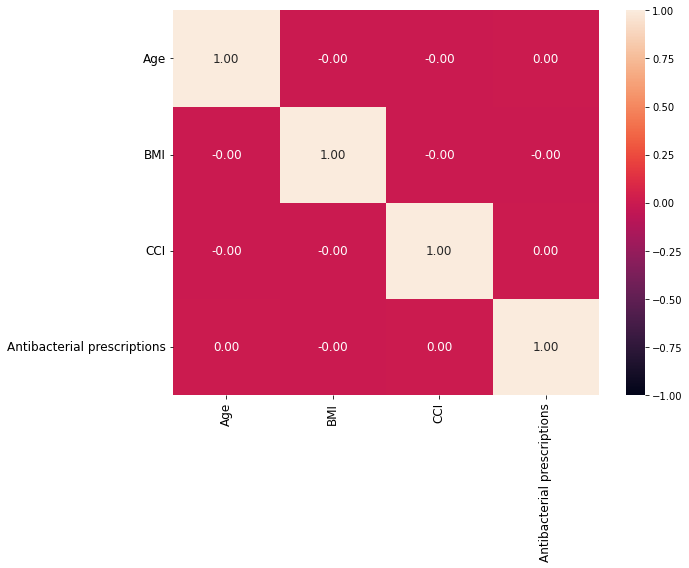

In [47]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data_urti[['age', 'bmi', 'CCI', 'antibacterial_brit']].corr(), 
            annot=True, fmt=".2f", annot_kws={"size":12},
            vmin=-1.0, vmax=1.0)

ax.set_xticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions'], rotation=90, fontsize=12)
ax.set_yticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions',], rotation=0, fontsize=12)                        
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/corr_urti.jpg')
plt.show()

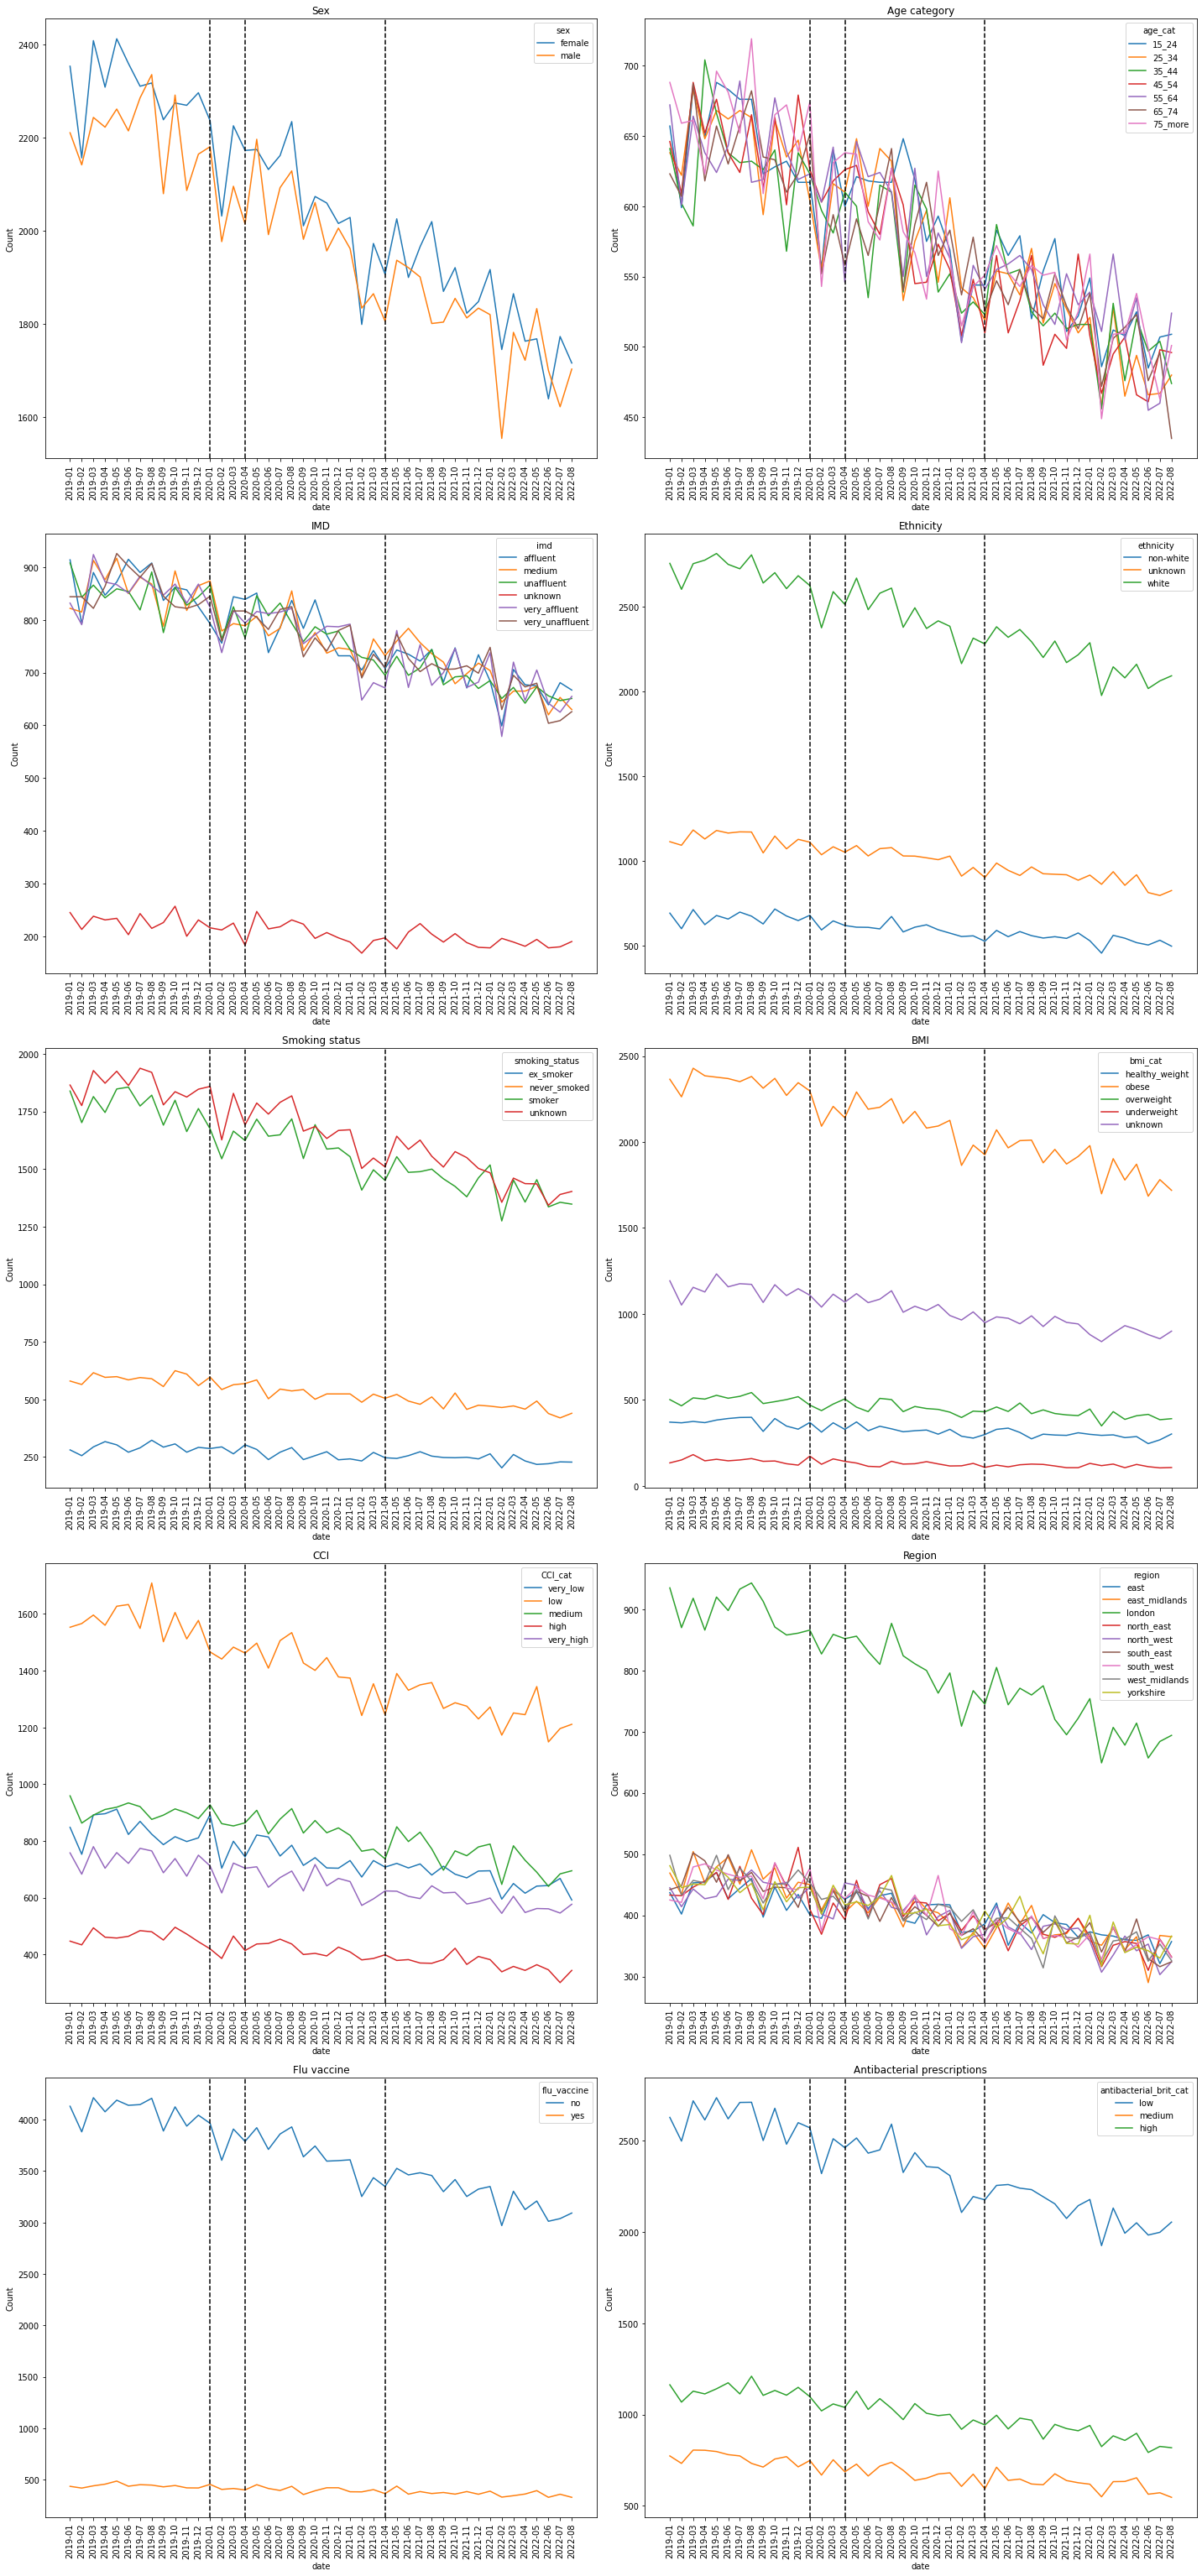

In [48]:
fig, axes = plt.subplots(5,2,
                        figsize=(20, 45)
                        )
create_lineplot(data_urti, 'sex', 'Sex', axes[0,0])
create_lineplot(data_urti, 'age_cat', 'Age category', axes[0,1])
create_lineplot(data_urti, 'imd', 'IMD', axes[1,0])
create_lineplot(data_urti, 'ethnicity', 'Ethnicity', axes[1,1])
create_lineplot(data_urti, 'smoking_status', 'Smoking status', axes[2,0])
create_lineplot(data_urti, 'bmi_cat', 'BMI', axes[2,1])
create_lineplot(data_urti, 'CCI_cat', 'CCI', axes[3,0])
create_lineplot(data_urti, 'region', 'Region', axes[3,1])
create_lineplot(data_urti, 'flu_vaccine', 'Flu vaccine', axes[4,0])
create_lineplot(data_urti, 'antibacterial_brit_cat', 'Antibacterial prescriptions', axes[4,1])
# fig.delaxes(ax=axes[5,1])

# fig.suptitle('Risk Factors of urti patients', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.98])
#plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/risk_factors_cat_urti.jpg')
plt.show()

## 4- separate data of incident/prevalent and with/without antibiotics
We separate data of urti to form four sub-datasets for 1) no antibiotics and incident admission, 2) with antibiotics and incident admission, 3) no antibiotics and prevalent admission, and 4) with antiobiotics and prevalent admission.

In [49]:
data_urti = data_urti[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 
                       'antibacterial_brit', 'urti_ab_date', 'ab_type_cat', 'incdt_urti_date', 'date', 'period',
                       'event_urti_admitted', 'duration_urti_admitted'
                        ]]

data_urti.shape

(177811, 17)

In [50]:
#incident and prevalent infection 
data_urti_incdt = data_urti[data_urti['incdt_urti_date'] == 0]
data_urti_prevl = data_urti[data_urti['incdt_urti_date'] == 1]
#switch variable urti_ab_date into a binary variable
data_urti_incdt[['urti_ab_date']] = data_urti_incdt[['urti_ab_date']].where(data_urti_incdt[['urti_ab_date']].isnull(), 1).fillna(0).astype(int)
data_urti_prevl[['urti_ab_date']] = data_urti_prevl[['urti_ab_date']].where(data_urti_prevl[['urti_ab_date']].isnull(), 1).fillna(0).astype(int)

#incident and prevalent infection stratified by sex categories
data_urti_incdt_males = data_urti_incdt[data_urti_incdt['sex'] == 'male']
data_urti_incdt_females = data_urti_incdt[data_urti_incdt['sex'] == 'female']
data_urti_prevl_males = data_urti_prevl[data_urti_prevl['sex'] == 'male']
data_urti_prevl_females = data_urti_prevl[data_urti_prevl['sex'] == 'female']

#incident and prevalent infection stratified by age categories
data_urti_incdt_15_24 = data_urti_incdt[data_urti_incdt['age_cat'] == '15_24']
data_urti_incdt_25_34 = data_urti_incdt[data_urti_incdt['age_cat'] == '25_34']
data_urti_incdt_35_44 = data_urti_incdt[data_urti_incdt['age_cat'] == '35_44']
data_urti_incdt_45_54 = data_urti_incdt[data_urti_incdt['age_cat'] == '45_54']
data_urti_incdt_55_64 = data_urti_incdt[data_urti_incdt['age_cat'] == '55_64']
data_urti_incdt_65_74 = data_urti_incdt[data_urti_incdt['age_cat'] == '65_74']
data_urti_incdt_75_more = data_urti_incdt[data_urti_incdt['age_cat'] == '75_more']
data_urti_prevl_15_24 = data_urti_prevl[data_urti_prevl['age_cat'] == '15_24']
data_urti_prevl_25_34 = data_urti_prevl[data_urti_prevl['age_cat'] == '25_34']
data_urti_prevl_35_44 = data_urti_prevl[data_urti_prevl['age_cat'] == '35_44']
data_urti_prevl_45_54 = data_urti_prevl[data_urti_prevl['age_cat'] == '45_54']
data_urti_prevl_55_64 = data_urti_prevl[data_urti_prevl['age_cat'] == '55_64']
data_urti_prevl_65_74 = data_urti_prevl[data_urti_prevl['age_cat'] == '65_74']
data_urti_prevl_75_more = data_urti_prevl[data_urti_prevl['age_cat'] == '75_more']

data_urti_incdt_prepandemic = data_urti_incdt[data_urti_incdt['date'] <= '2019-12']
data_urti_incdt_during_pandemic = data_urti_incdt[(data_urti_incdt['date'] >= '2020-03') & (data_urti_incdt['date']<= '2021-03')]
data_urti_incdt_post_2nd_lockdown = data_urti_incdt[data_urti_incdt['date'] <= '2021-04']
data_urti_prevl_prepandemic = data_urti_prevl[data_urti_prevl['date'] <= '2019-12']
data_urti_prevl_during_pandemic = data_urti_prevl[(data_urti_prevl['date'] >= '2020-03') & (data_urti_prevl['date']<= '2021-03')]
data_urti_prevl_post_2nd_lockdown = data_urti_prevl[data_urti_prevl['date'] <= '2021-04']

# #incident and prevalent infection stratified by ab categories
# data_urti_incdt_abtype_0 = data_urti_incdt[data_urti_incdt['ab_type_cat'] == data_urti['ab_type_cat'].unique()[0]]
# data_urti_incdt_abtype_1 = data_urti_incdt[data_urti_incdt['ab_type_cat'] == data_urti['ab_type_cat'].unique()[1]]
# data_urti_incdt_abtype_2 = data_urti_incdt[data_urti_incdt['ab_type_cat'] == data_urti['ab_type_cat'].unique()[2]]
# data_urti_incdt_abtype_3 = data_urti_incdt[data_urti_incdt['ab_type_cat'] == data_urti['ab_type_cat'].unique()[3]]
# data_urti_prevl_abtype_0 = data_urti_prevl[data_urti_prevl['ab_type_cat'] == data_urti['ab_type_cat'].unique()[0]]
# data_urti_prevl_abtype_1 = data_urti_prevl[data_urti_prevl['ab_type_cat'] == data_urti['ab_type_cat'].unique()[1]]
# data_urti_prevl_abtype_2 = data_urti_prevl[data_urti_prevl['ab_type_cat'] == data_urti['ab_type_cat'].unique()[2]]
# data_urti_prevl_abtype_3 = data_urti_prevl[data_urti_prevl['ab_type_cat'] == data_urti['ab_type_cat'].unique()[3]]

# #incident and prevalent infection with antibiotics type
# data_urti_incdt_abs = data_urti_incdt[data_urti_incdt['urti_ab_date'] == 1]
# data_urti_prevl_abs = data_urti_prevl[data_urti_prevl['urti_ab_date'] == 1]

# no antibiotics and incident hospital admission
data_urti_no_abs_incdt = data_urti[data_urti['urti_ab_date'].isnull()] #gp_cons_urti_ab
data_urti_no_abs_incdt = data_urti_no_abs_incdt[data_urti_no_abs_incdt['incdt_urti_date'] == 0]

# with antibiotics and incident hospital admission
data_urti_abs_incdt = data_urti[data_urti['urti_ab_date'].notnull()]
data_urti_abs_incdt = data_urti_abs_incdt[data_urti_abs_incdt['incdt_urti_date'] == 0]

# no antibiotics and prevalent hospital admission
data_urti_no_abs_prevl = data_urti[data_urti['urti_ab_date'].isnull()]
data_urti_no_abs_prevl = data_urti_no_abs_prevl[data_urti_no_abs_prevl['incdt_urti_date'] == 1]

# with antibiotics and prevalent hospital admission
data_urti_abs_prevl = data_urti[data_urti['urti_ab_date'].notnull()]
data_urti_abs_prevl = data_urti_abs_prevl[data_urti_abs_prevl['incdt_urti_date'] == 1]

print(f'shape of data_urti_incdt: {data_urti_incdt.shape}')
print(f'shape of data_urti_prevl: {data_urti_prevl.shape}')
print(f'shape of data_urti_no_abs_incdt: {data_urti_no_abs_incdt.shape}')
print(f'shape of data_urti_abs_incdt: {data_urti_abs_incdt.shape}')
print(f'shape of data_urti_no_abs_prevl: {data_urti_no_abs_prevl.shape}')
print(f'shape of data_urti_abs_prevl: {data_urti_abs_prevl.shape}')
print(f'\nvalue counts of data_urti_no_abs_incdt: \n{data_urti_no_abs_incdt.event_urti_admitted.value_counts()}')
print(f'value counts of data_urti_abs_incdt: \n{data_urti_abs_incdt.event_urti_admitted.value_counts()}')
print(f'value counts of data_urti_no_abs_prevl: \n{data_urti_no_abs_prevl.event_urti_admitted.value_counts()}')
print(f'value counts of data_urti_abs_prevl: \n{data_urti_abs_prevl.event_urti_admitted.value_counts()}')

shape of data_urti_incdt: (160323, 17)
shape of data_urti_prevl: (17488, 17)
shape of data_urti_no_abs_incdt: (144585, 17)
shape of data_urti_abs_incdt: (15738, 17)
shape of data_urti_no_abs_prevl: (15721, 17)
shape of data_urti_abs_prevl: (1767, 17)

value counts of data_urti_no_abs_incdt: 
0.0    143476
1.0      1109
Name: event_urti_admitted, dtype: int64
value counts of data_urti_abs_incdt: 
0.0    15626
1.0      112
Name: event_urti_admitted, dtype: int64
value counts of data_urti_no_abs_prevl: 
0.0    15599
1.0      122
Name: event_urti_admitted, dtype: int64
value counts of data_urti_abs_prevl: 
0.0    1759
1.0       8
Name: event_urti_admitted, dtype: int64


In [51]:
#store data for plotting hosp admission counts and percentages
%store data_urti
# save data
data_urti.to_csv('../output/hospitalisation_prediction_urti/data_urti.csv')

Stored 'data_urti' (DataFrame)


## 5- cox modelling for hospital admissions
### 5-1- incident urti with no antibiotics

<lifelines.CoxPHFitter: fitted with 108438 total observations, 107609 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 108438
number of events observed = 829
   partial log-likelihood = -9592.05
         time fit was run = 2022-11-17 16:05:06 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.06       0.94       0.10            -0.26             0.13                 0.77                 1.14
CCI_cat[T.medium]               -0.01       0.99       0.11            -0.22             0.21                 0.80                 1.23
CCI_cat[T.high]                 -0.07       0.93       0.14            -0.34             0.19                 0.71                 1.21
CCI_cat[T.very_high]            -0.11       0.89       0.12            -0.35             0.12                 0.71                 1.13
age_cat[T.25_34]                 0.19       1.21       0.13            -0.06             0.44                 0.94                 1.56
age_cat[T.35_44]                 0.12       1.13       0.13            -0.13             0.38                 0.87                 1.47
age_cat[T.45_54]                 0.08       1.08       0.13            -0.19             0.34                 0.83                 1.40
age_cat[T.55_64]                 0.10       1.11       0.13            -0.15             0.36                 0.86                 1.44
age_cat[T.65_74]                 0.05       1.05       0.13            -0.21             0.32                 0.81                 1.37
age_cat[T.75_more]               0.10       1.11       0.13            -0.16             0.36                 0.86                 1.44
antibacterial_brit              -0.00       1.00       0.02            -0.05             0.05                 0.95                 1.05
bmi_cat[T.obese]                 0.28       1.33       0.15            -0.01             0.58                 0.99                 1.78
bmi_cat[T.overweight]            0.48       1.62       0.17             0.15             0.81                 1.16                 2.26
bmi_cat[T.underweight]           0.33       1.39       0.24            -0.13             0.79                 0.88                 2.21
bmi_cat[T.unknown]               0.28       1.32       0.16            -0.03             0.58                 0.97                 1.79
ethnicity[T.unknown]             0.05       1.05       0.11            -0.18             0.27                 0.84                 1.31
ethnicity[T.white]               0.03       1.03       0.10            -0.17             0.23                 0.85                 1.26
flu_vaccine[T.yes]              -0.06       0.94       0.12            -0.29             0.17                 0.74                 1.19
imd[T.medium]                   -0.04       0.96       0.11            -0.26             0.18                 0.77                 1.20
imd[T.unaffluent]                0.03       1.03       0.11            -0.18             0.25                 0.83                 1.28
imd[T.unknown]                  -0.03       0.97       0.17            -0.37             0.30                 0.69                 1.35
imd[T.very_affluent]            -0.06       0.94       0.11            -0.28             0.16                 0.75                 1.17
imd[T.very_unaffluent]          -0.13       0.88       0.11            -0.36             0.09                 0.70                 1.10
region[T.east_midlands]          0.19       1.21       0.16            -0.11             0.50                 0.89                 1.65
region[T.london]                 0.10       1.10       0.14      

12773


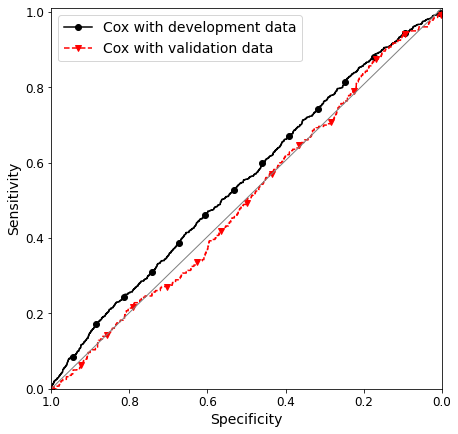

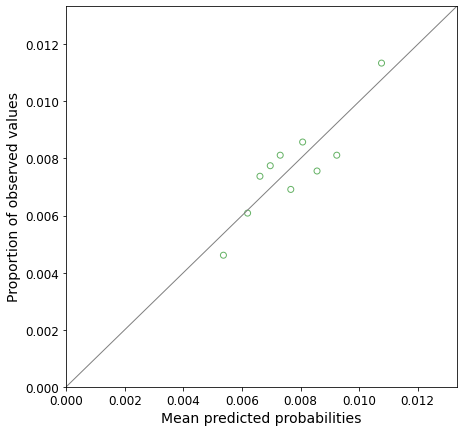

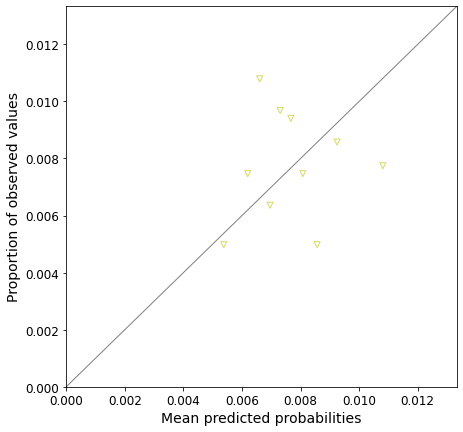

In [52]:
#data prep
data, data_urti_no_abs_incdt_enc = cox_data_prep(data_urti_no_abs_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

#make summary table
make_summary_table('urti', 'no_abs_incdt', data_urti_no_abs_incdt_enc)

#make summary table of hosped
make_summary_table_hosped('urti', 'no_abs_incdt', data_urti_no_abs_incdt)

try:
    #build cox model 
    cph_urti_no_abs_incdt, data_urti_no_abs_incdt_train, data_urti_no_abs_incdt_test = cox_model_build('urti', 'no_abs_incdt', data_urti_no_abs_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    betas_sumbetas_calculate(cph_urti_no_abs_incdt, '../output/hospitalisation_prediction_urti/', 'betas_cph_urti_no_abs_incdt.csv', data_urti_no_abs_incdt_enc, data_urti_no_abs_incdt, 'sum_betas_cph_urti_no_abs_incdt.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cph_roc_curve(cph_urti_no_abs_incdt, 'event_urti_admitted', data_urti_no_abs_incdt_train, data_urti_no_abs_incdt_test, '../output/hospitalisation_prediction_urti', 'roc_cph_urti_no_abs_incdt.jpg')

    #plot calibration plots with development and validation data
    cph_calibration(cph_urti_no_abs_incdt, data_urti_no_abs_incdt_train, 'event_urti_admitted', data_urti_no_abs_incdt_test, '../output/hospitalisation_prediction_urti/', 'calibration_cph_urti_no_abs_incdt_train.jpg', 'calibration_cph_urti_no_abs_incdt_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cph_output(cph_urti_no_abs_incdt, 'urti', 'no_abs_incdt', data_urti_no_abs_incdt_train, data_urti_no_abs_incdt_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-2- incident urti with antibiotics

<lifelines.CoxPHFitter: fitted with 11803 total observations, 11718 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 11803
number of events observed = 85
   partial log-likelihood = -774.80
         time fit was run = 2022-11-17 16:05:19 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.45       1.57       0.32            -0.18             1.08                 0.84                 2.93
CCI_cat[T.medium]                0.25       1.28       0.36            -0.46             0.95                 0.63                 2.59
CCI_cat[T.high]                 -0.34       0.71       0.53            -1.37             0.69                 0.25                 2.00
CCI_cat[T.very_high]            -0.43       0.65       0.45            -1.31             0.45                 0.27                 1.57
age_cat[T.25_34]                 0.14       1.15       0.42            -0.68             0.96                 0.51                 2.60
age_cat[T.35_44]                 0.21       1.24       0.41            -0.59             1.02                 0.55                 2.77
age_cat[T.45_54]                 0.31       1.36       0.40            -0.48             1.10                 0.62                 3.01
age_cat[T.55_64]                 0.36       1.43       0.40            -0.42             1.14                 0.66                 3.12
age_cat[T.65_74]                 0.25       1.29       0.41            -0.55             1.06                 0.58                 2.87
age_cat[T.75_more]              -0.47       0.62       0.48            -1.42             0.48                 0.24                 1.61
antibacterial_brit               0.06       1.06       0.08            -0.09             0.20                 0.91                 1.23
bmi_cat[T.obese]                -0.20       0.82       0.36            -0.91             0.51                 0.40                 1.67
bmi_cat[T.overweight]           -0.42       0.66       0.47            -1.35             0.50                 0.26                 1.66
bmi_cat[T.underweight]          -0.56       0.57       0.78            -2.09             0.98                 0.12                 2.66
bmi_cat[T.unknown]              -0.56       0.57       0.41            -1.37             0.25                 0.25                 1.29
ethnicity[T.unknown]            -0.34       0.72       0.39            -1.11             0.44                 0.33                 1.55
ethnicity[T.white]               0.17       1.19       0.32            -0.45             0.79                 0.64                 2.21
flu_vaccine[T.yes]              -0.22       0.80       0.40            -0.99             0.56                 0.37                 1.75
imd[T.medium]                   -0.78       0.46       0.40            -1.57             0.01                 0.21                 1.01
imd[T.unaffluent]               -0.09       0.92       0.33            -0.72             0.55                 0.49                 1.74
imd[T.unknown]                  -0.53       0.59       0.62            -1.74             0.69                 0.18                 1.99
imd[T.very_affluent]             0.27       1.31       0.30            -0.32             0.86                 0.72                 2.36
imd[T.very_unaffluent]          -0.66       0.52       0.39            -1.42             0.10                 0.24                 1.11
region[T.east_midlands]         -0.69       0.50       0.55            -1.77             0.38                 0.17                 1.46
region[T.london]                -0.45       0.63       0.42           

12772


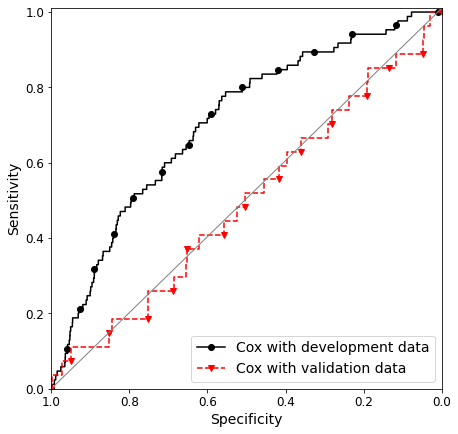

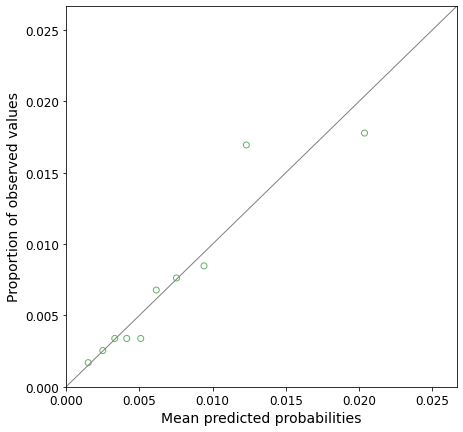

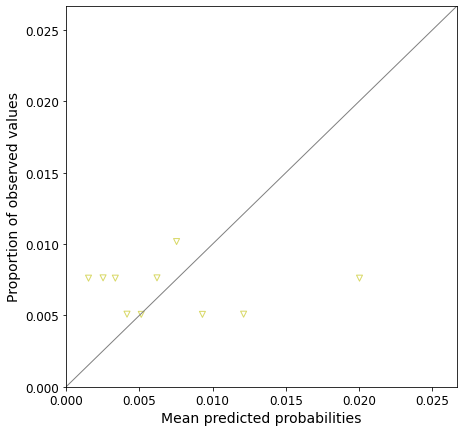

In [53]:
#data prep
data, data_urti_abs_incdt_enc = cox_data_prep(data_urti_abs_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

#make summary table
make_summary_table('urti', 'abs_incdt', data_urti_abs_incdt_enc)

#make summary table of hosped
make_summary_table_hosped('urti', 'abs_incdt', data_urti_abs_incdt)

try:
    #build cox model 
    cph_urti_abs_incdt, data_urti_abs_incdt_train, data_urti_abs_incdt_test = cox_model_build('urti', 'abs_incdt', data_urti_abs_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    betas_sumbetas_calculate(cph_urti_abs_incdt, '../output/hospitalisation_prediction_urti/', 'betas_cph_urti_abs_incdt.csv', data_urti_abs_incdt_enc, data_urti_abs_incdt, 'sum_betas_cph_urti_abs_incdt.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cph_roc_curve(cph_urti_abs_incdt, 'event_urti_admitted', data_urti_abs_incdt_train, data_urti_abs_incdt_test, '../output/hospitalisation_prediction_urti', 'roc_cph_urti_abs_incdt.jpg')

    #plot calibration plots with development and validation data
    cph_calibration(cph_urti_abs_incdt, data_urti_abs_incdt_train, 'event_urti_admitted', data_urti_abs_incdt_test, '../output/hospitalisation_prediction_urti/', 'calibration_cph_urti_abs_incdt_train.jpg', 'calibration_cph_urti_abs_incdt_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cph_output(cph_urti_abs_incdt, 'urti', 'abs_incdt', data_urti_abs_incdt_train, data_urti_abs_incdt_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-3- prevalent urti with no antibiotics

<lifelines.CoxPHFitter: fitted with 11790 total observations, 11700 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 11790
number of events observed = 90
   partial log-likelihood = -820.29
         time fit was run = 2022-11-17 16:05:22 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.25       1.28       0.32            -0.37             0.87                 0.69                 2.39
CCI_cat[T.medium]                0.20       1.22       0.35            -0.49             0.89                 0.61                 2.43
CCI_cat[T.high]                 -0.38       0.69       0.52            -1.40             0.65                 0.25                 1.91
CCI_cat[T.very_high]             0.41       1.51       0.36            -0.30             1.12                 0.74                 3.07
age_cat[T.25_34]                -0.38       0.68       0.48            -1.33             0.57                 0.26                 1.76
age_cat[T.35_44]                 0.21       1.23       0.41            -0.59             1.01                 0.55                 2.76
age_cat[T.45_54]                 0.30       1.35       0.40            -0.49             1.09                 0.61                 2.98
age_cat[T.55_64]                 0.56       1.74       0.38            -0.19             1.31                 0.82                 3.70
age_cat[T.65_74]                 0.09       1.10       0.43            -0.74             0.93                 0.47                 2.53
age_cat[T.75_more]               0.41       1.50       0.39            -0.36             1.18                 0.70                 3.24
antibacterial_brit              -0.16       0.86       0.08            -0.31             0.00                 0.73                 1.00
bmi_cat[T.obese]                -0.54       0.58       0.36            -1.24             0.15                 0.29                 1.17
bmi_cat[T.overweight]           -0.65       0.52       0.49            -1.62             0.32                 0.20                 1.38
bmi_cat[T.underweight]          -0.06       0.94       0.59            -1.23             1.10                 0.29                 3.00
bmi_cat[T.unknown]              -0.08       0.92       0.37            -0.80             0.64                 0.45                 1.89
ethnicity[T.unknown]             0.20       1.23       0.34            -0.46             0.87                 0.63                 2.38
ethnicity[T.white]              -0.08       0.92       0.31            -0.69             0.53                 0.50                 1.70
flu_vaccine[T.yes]              -0.43       0.65       0.42            -1.26             0.40                 0.28                 1.50
imd[T.medium]                   -0.17       0.84       0.36            -0.88             0.54                 0.41                 1.71
imd[T.unaffluent]                0.27       1.32       0.32            -0.36             0.91                 0.70                 2.48
imd[T.unknown]                  -0.80       0.45       0.75            -2.27             0.66                 0.10                 1.94
imd[T.very_affluent]            -0.33       0.72       0.38            -1.07             0.41                 0.34                 1.51
imd[T.very_unaffluent]           0.33       1.40       0.32            -0.29             0.96                 0.74                 2.62
region[T.east_midlands]          0.14       1.15       0.45            -0.75             1.02                 0.47                 2.77
region[T.london]                -0.28       0.75       0.43           

12769


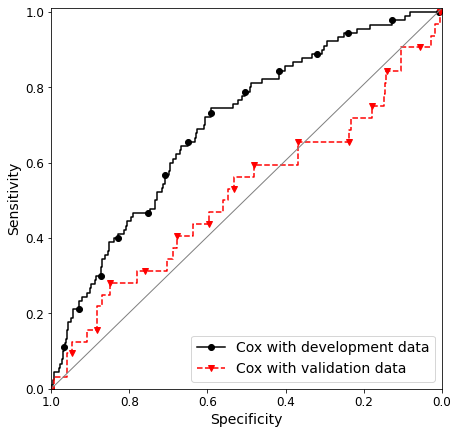

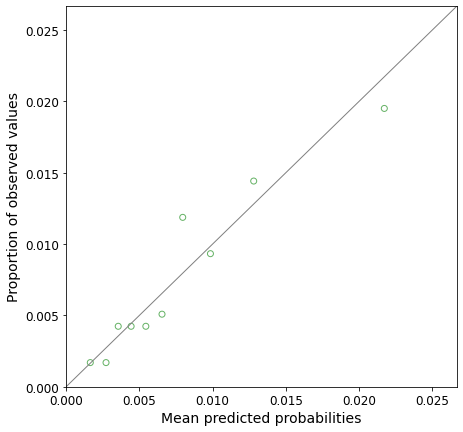

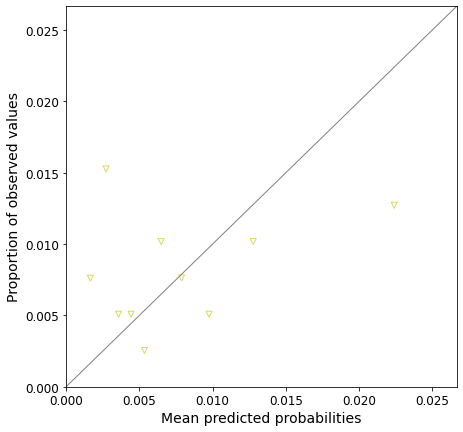

In [54]:
#data prep
data, data_urti_no_abs_prevl_enc = cox_data_prep(data_urti_no_abs_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

#make summary table
make_summary_table('urti', 'no_abs_prevl', data_urti_no_abs_prevl_enc)

#make summary table of hosped
make_summary_table_hosped('urti', 'no_abs_prevl', data_urti_no_abs_prevl)

try:
    #build cox model 
    cph_urti_no_abs_prevl, data_urti_no_abs_prevl_train, data_urti_no_abs_prevl_test = cox_model_build('urti', 'no_abs_prevl', data_urti_no_abs_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:    
    #calculate and save betas and sum of betas 
    betas_sumbetas_calculate(cph_urti_no_abs_prevl, '../output/hospitalisation_prediction_urti/', 'betas_cph_urti_no_abs_prevl.csv', data_urti_no_abs_prevl_enc, data_urti_no_abs_prevl, 'sum_betas_cph_urti_no_abs_prevl.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cph_roc_curve(cph_urti_no_abs_prevl, 'event_urti_admitted', data_urti_no_abs_prevl_train, data_urti_no_abs_prevl_test, '../output/hospitalisation_prediction_urti', 'roc_cph_urti_no_abs_prevl.jpg')

    #plot calibration plots with development and validation data
    cph_calibration(cph_urti_no_abs_prevl, data_urti_no_abs_prevl_train, 'event_urti_admitted', data_urti_no_abs_prevl_test, '../output/hospitalisation_prediction_urti/', 'calibration_cph_urti_no_abs_prevl_train.jpg', 'calibration_cph_urti_no_abs_prevl_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cph_output(cph_urti_no_abs_prevl, 'urti', 'no_abs_prevl', data_urti_no_abs_prevl_train, data_urti_no_abs_prevl_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-4- prevalent urti with antibiotics

<lifelines.CoxPHFitter: fitted with 1325 total observations, 1320 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 1325
number of events observed = 5
   partial log-likelihood = -12.72
         time fit was run = 2022-11-17 16:05:25 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.37       1.45       2.28            -4.10             4.84                 0.02               126.76
CCI_cat[T.medium]               -2.14       0.12       3.84            -9.66             5.39                 0.00               218.44
CCI_cat[T.high]                 -1.72       0.18       3.57            -8.70             5.27                 0.00               194.70
CCI_cat[T.very_high]             1.34       3.84       2.91            -4.35             7.04                 0.01              1144.21
age_cat[T.25_34]                -0.19       0.83       8.11           -16.08            15.71                 0.00             6.63e+06
age_cat[T.35_44]                 3.64      37.97       4.13            -4.45            11.73                 0.01             1.24e+05
age_cat[T.45_54]                 3.38      29.24       4.05            -4.55            11.30                 0.01             81173.65
age_cat[T.55_64]                 0.38       1.46       5.31           -10.02            10.78                 0.00             48107.07
age_cat[T.65_74]                 2.82      16.83       3.94            -4.90            10.55                 0.01             38165.30
age_cat[T.75_more]               3.72      41.23       4.07            -4.26            11.70                 0.01             1.21e+05
antibacterial_brit               0.02       1.02       0.55            -1.06             1.11                 0.35                 3.03
bmi_cat[T.obese]                -2.44       0.09       2.39            -7.11             2.24                 0.00                 9.35
bmi_cat[T.overweight]           -4.20       0.02       6.85           -17.62             9.23                 0.00             10214.82
bmi_cat[T.underweight]          -1.78       0.17       3.02            -7.70             4.14                 0.00                62.98
bmi_cat[T.unknown]              -2.70       0.07       2.83            -8.24             2.84                 0.00                17.04
ethnicity[T.unknown]            -4.65       0.01       4.15           -12.78             3.49                 0.00                32.80
ethnicity[T.white]              -1.41       0.24       1.48            -4.31             1.48                 0.01                 4.40
flu_vaccine[T.yes]              -2.67       0.07       8.40           -19.14            13.80                 0.00             9.83e+05
imd[T.medium]                    2.24       9.36       4.61            -6.80            11.27                 0.00             78752.61
imd[T.unaffluent]                3.57      35.37       4.49            -5.24            12.37                 0.01             2.36e+05
imd[T.unknown]                   4.88     131.96       4.78            -4.48            14.24                 0.01             1.53e+06
imd[T.very_affluent]             3.31      27.39       4.41            -5.34            11.96                 0.00             1.56e+05
imd[T.very_unaffluent]           0.30       1.35       5.81           -11.08            11.68                 0.00             1.18e+05
region[T.east_midlands]          2.30       9.99      11.52           -20.27            24.88                 0.00             6.36e+10
region[T.london]                 4.64     103.19       9.49           -13.9

12919


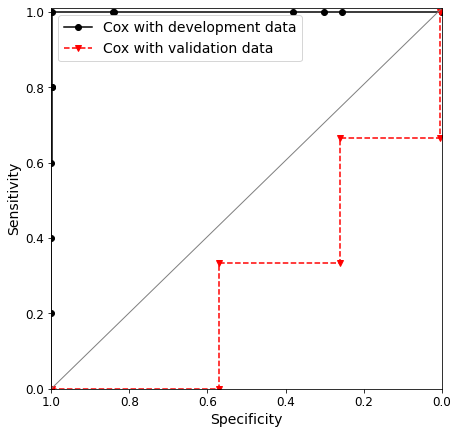

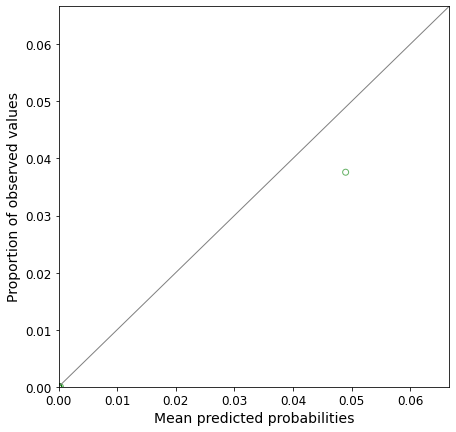

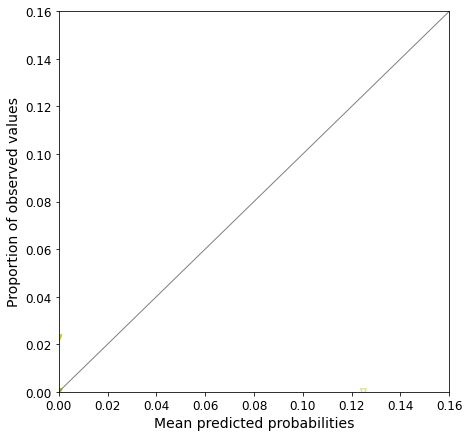

In [55]:
#data prep
data, data_urti_abs_prevl_enc = cox_data_prep(data_urti_abs_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

#make summary table
make_summary_table('urti', 'abs_prevl', data_urti_abs_prevl_enc)

#make summary table of hosped
make_summary_table_hosped('urti', 'abs_prevl', data_urti_abs_prevl)

try:
    #build cox model 
    cph_urti_abs_prevl, data_urti_abs_prevl_train, data_urti_abs_prevl_test = cox_model_build('urti', 'abs_prevl', data_urti_abs_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    betas_sumbetas_calculate(cph_urti_abs_prevl, '../output/hospitalisation_prediction_urti/', 'betas_cph_urti_abs_prevl.csv', data_urti_abs_prevl_enc, data_urti_abs_prevl, 'sum_betas_cph_urti_abs_prevl.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cph_roc_curve(cph_urti_abs_prevl, 'event_urti_admitted', data_urti_abs_prevl_train, data_urti_abs_prevl_test, '../output/hospitalisation_prediction_urti', 'roc_cph_urti_abs_prevl.jpg')

    #plot calibration plots with development and validation data
    cph_calibration(cph_urti_abs_prevl, data_urti_abs_prevl_train, 'event_urti_admitted', data_urti_abs_prevl_test, '../output/hospitalisation_prediction_urti/', 'calibration_cph_urti_abs_prevl_train.jpg', 'calibration_cph_urti_abs_prevl_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cph_output(cph_urti_abs_prevl, 'urti', 'abs_prevl', data_urti_abs_prevl_train, data_urti_abs_prevl_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-5- incident urti

In [56]:
#data prep
data, data_urti_incdt_enc = cox_data_prep(data_urti_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

#make summary tables from preped data
make_summary_table('urti', 'incdt', data_urti_incdt_enc)
make_summary_table_hosped('urti', 'incdt', data_urti_incdt)

try:
    cph_urti_incdt, data_urti_incdt_train, data_urti_incdt_test = cox_model_abs_build('urti', 'incdt', data_urti_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_urti_incdt, 'urti', 'incdt', data_urti_incdt_train, data_urti_incdt_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 120242 total observations, 119335 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 120242
number of events observed = 907
   partial log-likelihood = -10588.59
         time fit was run = 2022-11-17 16:05:29 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.02       1.02       0.10            -0.16             0.21                 0.85                 1.24
CCI_cat[T.medium]                0.01       1.01       0.11            -0.20             0.22                 0.82                 1.25
CCI_cat[T.high]                  0.06       1.06       0.13            -0.19             0.31                 0.83                 1.37
CCI_cat[T.very_high]            -0.05       0.95       0.11            -0.27             0.18                 0.76                 1.19
age_cat[T.25_34]                 0.21       1.24       0.13            -0.04             0.47                 0.96                 1.59
age_cat[T.35_44]                 0.26       1.29       0.13             0.00             0.51                 1.00                 1.66
age_cat[T.45_54]                 0.17       1.19       0.13            -0.08             0.43                 0.92                 1.53
age_cat[T.55_64]                 0.24       1.27       0.13            -0.01             0.49                 0.99                 1.63
age_cat[T.65_74]                 0.15       1.16       0.13            -0.11             0.41                 0.90                 1.50
age_cat[T.75_more]               0.21       1.23       0.13            -0.04             0.46                 0.96                 1.58
antibacterial_brit              -0.00       1.00       0.02            -0.05             0.04                 0.95                 1.04
bmi_cat[T.obese]                 0.27       1.31       0.14            -0.01             0.54                 0.99                 1.72
bmi_cat[T.overweight]            0.54       1.72       0.16             0.23             0.85                 1.26                 2.34
bmi_cat[T.underweight]           0.26       1.30       0.23            -0.19             0.71                 0.83                 2.03
bmi_cat[T.unknown]               0.22       1.24       0.15            -0.08             0.51                 0.93                 1.67
ethnicity[T.unknown]             0.09       1.10       0.11            -0.13             0.31                 0.88                 1.36
ethnicity[T.white]               0.08       1.08       0.10            -0.12             0.27                 0.89                 1.31
flu_vaccine[T.yes]              -0.04       0.96       0.11            -0.26             0.18                 0.77                 1.20
imd[T.medium]                   -0.08       0.93       0.11            -0.29             0.13                 0.75                 1.14
imd[T.unaffluent]               -0.07       0.93       0.11            -0.28             0.14                 0.76                 1.15
imd[T.unknown]                  -0.06       0.94       0.16            -0.38             0.27                 0.68                 1.31
imd[T.very_affluent]            -0.05       0.95       0.11            -0.26             0.16                 0.77                 1.17
imd[T.very_unaffluent]          -0.06       0.94       0.11            -0.27             0.15                 0.76                 1.16
region[T.east_midlands]          0.04       1.04       0.15            -0.25             0.32                 0.78                 1.38
region[T.london]                -0.11       0.90       0.13     

13049


### 5-6- hospital admission related to prevalent urti

In [57]:
#data prep
data, data_urti_prevl_enc = cox_data_prep(data_urti_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

#make summary tables from preped data
make_summary_table('urti', 'prevl', data_urti_prevl_enc)
make_summary_table_hosped('urti', 'prevl', data_urti_prevl)

try:
    cph_urti_prevl, data_urti_prevl_train, data_urti_prevl_test = cox_model_abs_build('urti', 'prevl', data_urti_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_urti_prevl, 'urti', 'prevl', data_urti_prevl_train, data_urti_prevl_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 13116 total observations, 13020 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 13116
number of events observed = 96
   partial log-likelihood = -881.75
         time fit was run = 2022-11-17 16:05:33 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.50       1.65       0.33            -0.15             1.15                 0.86                 3.15
CCI_cat[T.medium]                0.52       1.68       0.36            -0.18             1.23                 0.83                 3.41
CCI_cat[T.high]                 -0.27       0.76       0.53            -1.32             0.77                 0.27                 2.16
CCI_cat[T.very_high]             0.65       1.91       0.37            -0.08             1.37                 0.92                 3.93
age_cat[T.25_34]                -0.19       0.82       0.44            -1.06             0.67                 0.35                 1.96
age_cat[T.35_44]                -0.03       0.97       0.42            -0.85             0.78                 0.43                 2.19
age_cat[T.45_54]                 0.43       1.54       0.37            -0.30             1.16                 0.74                 3.20
age_cat[T.55_64]                 0.14       1.15       0.40            -0.64             0.93                 0.52                 2.52
age_cat[T.65_74]                 0.55       1.73       0.37            -0.17             1.27                 0.84                 3.58
age_cat[T.75_more]               0.16       1.17       0.39            -0.61             0.93                 0.54                 2.54
antibacterial_brit              -0.11       0.90       0.08            -0.26             0.04                 0.77                 1.04
bmi_cat[T.obese]                -0.20       0.82       0.39            -0.96             0.55                 0.38                 1.74
bmi_cat[T.overweight]           -0.18       0.83       0.49            -1.14             0.77                 0.32                 2.17
bmi_cat[T.underweight]           0.25       1.28       0.61            -0.96             1.45                 0.38                 4.27
bmi_cat[T.unknown]               0.15       1.16       0.40            -0.63             0.93                 0.53                 2.53
ethnicity[T.unknown]             0.24       1.28       0.34            -0.42             0.90                 0.66                 2.47
ethnicity[T.white]               0.00       1.00       0.31            -0.60             0.61                 0.55                 1.84
flu_vaccine[T.yes]              -0.29       0.75       0.39            -1.06             0.48                 0.35                 1.61
imd[T.medium]                   -0.21       0.81       0.36            -0.91             0.48                 0.40                 1.62
imd[T.unaffluent]                0.34       1.41       0.31            -0.26             0.95                 0.77                 2.59
imd[T.unknown]                  -0.82       0.44       0.75            -2.28             0.64                 0.10                 1.90
imd[T.very_affluent]            -0.06       0.94       0.34            -0.72             0.60                 0.48                 1.83
imd[T.very_unaffluent]           0.14       1.15       0.33            -0.50             0.77                 0.61                 2.17
region[T.east_midlands]          0.45       1.58       0.48            -0.49             1.40                 0.61                 4.07
region[T.london]                 0.10       1.11       0.46           

13031


### 5-7- hospital admission related to incident urti with prescribed antibiotics categories

In [58]:
#data prep
data, data_urti_incdt_abs_enc = cox_data_prep(data_urti_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ab_type_cat'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_incdt_abs, data_urti_incdt_abs_train, data_urti_incdt_abs_test = cox_model_ab_type_build('urti', 'incdt_ab_type', data_urti_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_urti_incdt_abs, 'urti', 'incdt_abs', data_urti_incdt_abs_train, data_urti_incdt_abs_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 120242 total observations, 119335 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 120242
number of events observed = 907
   partial log-likelihood = -10587.78
         time fit was run = 2022-11-17 16:05:36 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.02       1.03       0.10            -0.16             0.21                 0.85                 1.24
CCI_cat[T.medium]                0.01       1.01       0.11            -0.20             0.22                 0.82                 1.25
CCI_cat[T.high]                  0.06       1.06       0.13            -0.19             0.31                 0.83                 1.37
CCI_cat[T.very_high]            -0.05       0.95       0.11            -0.27             0.18                 0.76                 1.19
ab_type_cat[T.Doxycycline]      -0.80       0.45       1.07            -2.89             1.30                 0.06                 3.65
ab_type_cat[T.no]               -0.28       0.76       0.38            -1.02             0.46                 0.36                 1.59
ab_type_cat[T.other]            -0.53       0.59       0.40            -1.30             0.25                 0.27                 1.29
age_cat[T.25_34]                 0.21       1.24       0.13            -0.04             0.47                 0.96                 1.59
age_cat[T.35_44]                 0.26       1.29       0.13             0.00             0.51                 1.00                 1.66
age_cat[T.45_54]                 0.17       1.19       0.13            -0.08             0.43                 0.92                 1.53
age_cat[T.55_64]                 0.24       1.27       0.13            -0.01             0.49                 0.99                 1.63
age_cat[T.65_74]                 0.15       1.16       0.13            -0.11             0.41                 0.90                 1.50
age_cat[T.75_more]               0.21       1.23       0.13            -0.04             0.46                 0.96                 1.58
antibacterial_brit              -0.00       1.00       0.02            -0.05             0.04                 0.95                 1.04
bmi_cat[T.obese]                 0.27       1.31       0.14            -0.01             0.55                 0.99                 1.72
bmi_cat[T.overweight]            0.54       1.72       0.16             0.23             0.85                 1.26                 2.34
bmi_cat[T.underweight]           0.26       1.30       0.23            -0.19             0.71                 0.83                 2.03
bmi_cat[T.unknown]               0.22       1.24       0.15            -0.08             0.51                 0.93                 1.67
ethnicity[T.unknown]             0.09       1.10       0.11            -0.13             0.31                 0.88                 1.36
ethnicity[T.white]               0.08       1.08       0.10            -0.12             0.27                 0.89                 1.31
flu_vaccine[T.yes]              -0.04       0.96       0.11            -0.26             0.18                 0.77                 1.20
imd[T.medium]                   -0.08       0.93       0.11            -0.29             0.13                 0.75                 1.14
imd[T.unaffluent]               -0.07       0.93       0.11            -0.28             0.14                 0.76                 1.15
imd[T.unknown]                  -0.06       0.94       0.16            -0.38             0.27                 0.68                 1.31
imd[T.very_affluent]            -0.05       0.95       0.11     

13616


### 5-8- hospital admission related to prevalent urti with prescribed antibiotics categories

In [59]:
#data prep
data, data_urti_prevl_abs_enc = cox_data_prep(data_urti_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ab_type_cat'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_prevl_abs, data_urti_prevl_abs_train, data_urti_prevl_abs_test = cox_model_ab_type_build('urti', 'prevl_ab_type', data_urti_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_urti_prevl_abs, 'urti', 'prevl_abs', data_urti_prevl_abs_train, data_urti_prevl_abs_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 13116 total observations, 13020 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 13116
number of events observed = 96
   partial log-likelihood = -881.22
         time fit was run = 2022-11-17 16:05:40 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.50       1.64       0.33            -0.15             1.15                 0.86                 3.15
CCI_cat[T.medium]                0.52       1.68       0.36            -0.18             1.22                 0.83                 3.40
CCI_cat[T.high]                 -0.27       0.76       0.53            -1.32             0.77                 0.27                 2.16
CCI_cat[T.very_high]             0.65       1.91       0.37            -0.08             1.37                 0.93                 3.94
ab_type_cat[T.Doxycycline]     -14.56       0.00    2103.03         -4136.42          4107.30                 0.00                  inf
ab_type_cat[T.no]               -0.56       0.57       1.01            -2.53             1.42                 0.08                 4.14
ab_type_cat[T.other]            -1.00       0.37       1.08            -3.13             1.12                 0.04                 3.06
age_cat[T.25_34]                -0.20       0.82       0.44            -1.07             0.66                 0.34                 1.94
age_cat[T.35_44]                -0.04       0.96       0.42            -0.86             0.78                 0.42                 2.18
age_cat[T.45_54]                 0.43       1.54       0.37            -0.30             1.16                 0.74                 3.20
age_cat[T.55_64]                 0.13       1.14       0.40            -0.65             0.92                 0.52                 2.51
age_cat[T.65_74]                 0.55       1.73       0.37            -0.17             1.27                 0.84                 3.58
age_cat[T.75_more]               0.16       1.17       0.39            -0.61             0.93                 0.54                 2.54
antibacterial_brit              -0.11       0.90       0.08            -0.26             0.04                 0.77                 1.04
bmi_cat[T.obese]                -0.20       0.81       0.39            -0.96             0.55                 0.38                 1.73
bmi_cat[T.overweight]           -0.18       0.83       0.49            -1.14             0.77                 0.32                 2.17
bmi_cat[T.underweight]           0.25       1.28       0.61            -0.95             1.45                 0.39                 4.28
bmi_cat[T.unknown]               0.15       1.16       0.40            -0.63             0.93                 0.53                 2.53
ethnicity[T.unknown]             0.24       1.27       0.34            -0.42             0.90                 0.66                 2.46
ethnicity[T.white]              -0.00       1.00       0.31            -0.61             0.60                 0.54                 1.83
flu_vaccine[T.yes]              -0.29       0.75       0.39            -1.06             0.48                 0.35                 1.62
imd[T.medium]                   -0.21       0.81       0.36            -0.91             0.49                 0.40                 1.63
imd[T.unaffluent]                0.34       1.41       0.31            -0.26             0.95                 0.77                 2.59
imd[T.unknown]                  -0.82       0.44       0.75            -2.29             0.64                 0.10                 1.89
imd[T.very_affluent]            -0.06       0.94       0.34           

13609


### 5-9- stratified by sex
#### 5-9-1- incident males

In [60]:
#data prep
data, data_urti_incdt_males_enc = cox_data_prep(data_urti_incdt_males, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_incdt_males, data_urti_incdt_males_train, data_urti_incdt_males_test = cox_model_strat_sex_build('urti', 'incdt_males', data_urti_incdt_males)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_urti_incdt_males, 'urti', 'incdt_males', data_urti_incdt_males_train, data_urti_incdt_males_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 59074 total observations, 58626 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 59074
number of events observed = 448
   partial log-likelihood = -4893.87
         time fit was run = 2022-11-17 16:05:42 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.02       1.02       0.13            -0.24             0.28                 0.79                 1.33
CCI_cat[T.medium]               -0.14       0.87       0.16            -0.45             0.16                 0.64                 1.18
CCI_cat[T.high]                  0.11       1.12       0.18            -0.23             0.46                 0.79                 1.58
CCI_cat[T.very_high]            -0.12       0.88       0.16            -0.45             0.20                 0.64                 1.22
age_cat[T.25_34]                 0.62       1.85       0.19             0.25             0.98                 1.29                 2.67
age_cat[T.35_44]                 0.37       1.45       0.20            -0.01             0.76                 0.99                 2.13
age_cat[T.45_54]                 0.40       1.50       0.19             0.03             0.78                 1.03                 2.19
age_cat[T.55_64]                 0.30       1.35       0.20            -0.09             0.68                 0.92                 1.98
age_cat[T.65_74]                 0.43       1.54       0.19             0.06             0.81                 1.06                 2.25
age_cat[T.75_more]               0.31       1.36       0.20            -0.07             0.69                 0.93                 2.00
antibacterial_brit               0.05       1.05       0.03            -0.01             0.11                 0.99                 1.12
bmi_cat[T.obese]                 0.37       1.45       0.21            -0.04             0.78                 0.96                 2.19
bmi_cat[T.overweight]            0.65       1.91       0.24             0.18             1.11                 1.20                 3.02
bmi_cat[T.underweight]           0.40       1.50       0.33            -0.24             1.04                 0.79                 2.84
bmi_cat[T.unknown]               0.38       1.47       0.22            -0.05             0.82                 0.95                 2.26
ethnicity[T.unknown]             0.26       1.30       0.17            -0.07             0.59                 0.93                 1.81
ethnicity[T.white]               0.31       1.36       0.15             0.01             0.61                 1.01                 1.84
flu_vaccine[T.yes]               0.07       1.08       0.15            -0.22             0.37                 0.80                 1.45
imd[T.medium]                   -0.02       0.98       0.15            -0.32             0.28                 0.72                 1.32
imd[T.unaffluent]                0.04       1.04       0.15            -0.26             0.34                 0.77                 1.40
imd[T.unknown]                  -0.03       0.97       0.24            -0.49             0.43                 0.61                 1.54
imd[T.very_affluent]             0.10       1.11       0.15            -0.19             0.40                 0.82                 1.49
imd[T.very_unaffluent]          -0.15       0.86       0.16            -0.46             0.17                 0.63                 1.18
region[T.east_midlands]          0.31       1.36       0.21            -0.10             0.72                 0.90                 2.05
region[T.london]                 0.14       1.15       0.19         

12760


#### 5-9-2- incident females

In [61]:
#data prep
data, data_urti_incdt_females_enc = cox_data_prep(data_urti_incdt_females, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_incdt_females, data_urti_incdt_females_train, data_urti_incdt_females_test = cox_model_strat_sex_build('urti', 'incdt_females', data_urti_incdt_females)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_urti_incdt_females, 'urti', 'incdt_females', data_urti_incdt_females_train, data_urti_incdt_females_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 61167 total observations, 60705 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 61167
number of events observed = 462
   partial log-likelihood = -5078.44
         time fit was run = 2022-11-17 16:05:44 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.03       1.03       0.13            -0.23             0.29                 0.79                 1.34
CCI_cat[T.medium]               -0.16       0.85       0.15            -0.47             0.14                 0.63                 1.15
CCI_cat[T.high]                 -0.07       0.93       0.18            -0.43             0.29                 0.65                 1.34
CCI_cat[T.very_high]             0.11       1.11       0.15            -0.19             0.41                 0.83                 1.50
age_cat[T.25_34]                 0.19       1.21       0.17            -0.15             0.53                 0.86                 1.69
age_cat[T.35_44]                 0.03       1.03       0.18            -0.32             0.38                 0.73                 1.46
age_cat[T.45_54]                 0.10       1.11       0.18            -0.24             0.45                 0.78                 1.57
age_cat[T.55_64]                 0.17       1.18       0.17            -0.17             0.50                 0.84                 1.66
age_cat[T.65_74]                -0.02       0.98       0.18            -0.38             0.33                 0.68                 1.40
age_cat[T.75_more]               0.04       1.04       0.18            -0.31             0.39                 0.74                 1.48
antibacterial_brit               0.04       1.04       0.03            -0.02             0.11                 0.98                 1.11
bmi_cat[T.obese]                 0.10       1.10       0.19            -0.27             0.46                 0.77                 1.59
bmi_cat[T.overweight]            0.16       1.17       0.22            -0.27             0.59                 0.76                 1.80
bmi_cat[T.underweight]           0.18       1.20       0.30            -0.42             0.78                 0.66                 2.18
bmi_cat[T.unknown]               0.12       1.13       0.20            -0.27             0.50                 0.77                 1.66
ethnicity[T.unknown]             0.15       1.16       0.15            -0.16             0.45                 0.85                 1.57
ethnicity[T.white]               0.06       1.06       0.14            -0.21             0.34                 0.81                 1.40
flu_vaccine[T.yes]              -0.14       0.87       0.17            -0.46             0.19                 0.63                 1.21
imd[T.medium]                    0.02       1.02       0.15            -0.27             0.32                 0.76                 1.37
imd[T.unaffluent]                0.06       1.06       0.15            -0.24             0.35                 0.79                 1.42
imd[T.unknown]                  -0.12       0.88       0.25            -0.61             0.36                 0.54                 1.44
imd[T.very_affluent]             0.09       1.10       0.15            -0.20             0.39                 0.82                 1.47
imd[T.very_unaffluent]          -0.10       0.91       0.16            -0.40             0.21                 0.67                 1.23
region[T.east_midlands]         -0.34       0.71       0.21            -0.75             0.08                 0.47                 1.08
region[T.london]                -0.25       0.78       0.18         

12760


#### 5-9-3- prevalent males

In [62]:
#data prep
data, data_urti_prevl_males_enc = cox_data_prep(data_urti_prevl_males, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_prevl_males, data_urti_prevl_males_train, data_urti_prevl_males_test = cox_model_strat_sex_build('urti', 'prevl_males', data_urti_prevl_males)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:  
    # calculate c-statistics
    cph_output(cph_urti_prevl_males, 'urti', 'prevl_males', data_urti_prevl_males_train, data_urti_prevl_males_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 6399 total observations, 6344 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 6399
number of events observed = 55
   partial log-likelihood = -460.94
         time fit was run = 2022-11-17 16:05:47 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.70       2.02       0.46            -0.20             1.60                 0.82                 4.94
CCI_cat[T.medium]                0.58       1.78       0.50            -0.40             1.56                 0.67                 4.77
CCI_cat[T.high]                 -0.06       0.94       0.71            -1.45             1.33                 0.24                 3.79
CCI_cat[T.very_high]             0.68       1.98       0.52            -0.33             1.70                 0.72                 5.45
age_cat[T.25_34]                 0.19       1.21       0.63            -1.05             1.43                 0.35                 4.19
age_cat[T.35_44]                 0.71       2.03       0.56            -0.39             1.80                 0.68                 6.06
age_cat[T.45_54]                 0.25       1.28       0.61            -0.94             1.44                 0.39                 4.23
age_cat[T.55_64]                 0.86       2.37       0.54            -0.20             1.92                 0.82                 6.84
age_cat[T.65_74]                 0.94       2.55       0.54            -0.12             2.00                 0.88                 7.37
age_cat[T.75_more]               0.53       1.70       0.57            -0.59             1.65                 0.55                 5.21
antibacterial_brit              -0.16       0.85       0.10            -0.36             0.05                 0.70                 1.05
bmi_cat[T.obese]                 0.87       2.38       0.73            -0.57             2.30                 0.57                 9.99
bmi_cat[T.overweight]            0.65       1.91       0.84            -1.00             2.29                 0.37                 9.91
bmi_cat[T.underweight]           1.01       2.73       1.00            -0.96             2.97                 0.38                19.55
bmi_cat[T.unknown]               0.90       2.45       0.76            -0.58             2.38                 0.56                10.76
ethnicity[T.unknown]             0.30       1.35       0.43            -0.55             1.14                 0.58                 3.13
ethnicity[T.white]              -0.09       0.91       0.40            -0.87             0.69                 0.42                 2.00
flu_vaccine[T.yes]              -0.34       0.71       0.52            -1.36             0.68                 0.26                 1.98
imd[T.medium]                   -0.25       0.78       0.47            -1.16             0.67                 0.31                 1.95
imd[T.unaffluent]                0.18       1.20       0.41            -0.63             0.99                 0.53                 2.68
imd[T.unknown]                 -16.84       0.00    2801.72         -5508.10          5474.43                 0.00                  inf
imd[T.very_affluent]             0.25       1.28       0.41            -0.55             1.04                 0.58                 2.83
imd[T.very_unaffluent]          -0.12       0.89       0.45            -1.01             0.76                 0.37                 2.14
region[T.east_midlands]          0.56       1.76       0.63            -0.67             1.80                 0.51                 6.02
region[T.london]                 0.34       1.40       0.59            -0

12764


#### 5-9-4- prevalent females

In [63]:
try:
    #data prep
    data, data_urti_prevl_females_enc = cox_data_prep(data_urti_prevl_females, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

    #cox model
    cph_urti_prevl_females, data_urti_prevl_females_train, data_urti_prevl_females_test = cox_model_strat_sex_build('urti', 'prevl_females', data_urti_prevl_females)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_urti_prevl_females, 'urti', 'prevl_females', data_urti_prevl_females_train, data_urti_prevl_females_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 6717 total observations, 6683 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 6717
number of events observed = 34
   partial log-likelihood = -274.28
         time fit was run = 2022-11-17 16:05:47 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.08       1.09       0.51            -0.92             1.09                 0.40                 2.97
CCI_cat[T.medium]                0.21       1.23       0.55            -0.86             1.28                 0.42                 3.58
CCI_cat[T.high]                  0.26       1.30       0.65            -1.01             1.54                 0.36                 4.65
CCI_cat[T.very_high]             0.12       1.13       0.61            -1.07             1.31                 0.34                 3.72
age_cat[T.25_34]                -0.29       0.75       0.68            -1.61             1.03                 0.20                 2.81
age_cat[T.35_44]                -1.62       0.20       1.10            -3.78             0.53                 0.02                 1.69
age_cat[T.45_54]                 0.34       1.40       0.57            -0.79             1.46                 0.45                 4.31
age_cat[T.55_64]                 0.19       1.21       0.59            -0.97             1.35                 0.38                 3.84
age_cat[T.65_74]                -0.61       0.54       0.73            -2.05             0.82                 0.13                 2.28
age_cat[T.75_more]               0.04       1.04       0.61            -1.15             1.24                 0.32                 3.44
antibacterial_brit              -0.03       0.97       0.13            -0.28             0.21                 0.76                 1.24
bmi_cat[T.obese]                -1.31       0.27       0.52            -2.34            -0.29                 0.10                 0.75
bmi_cat[T.overweight]           -0.86       0.42       0.71            -2.26             0.53                 0.10                 1.71
bmi_cat[T.underweight]          -0.15       0.86       0.83            -1.77             1.47                 0.17                 4.33
bmi_cat[T.unknown]              -0.32       0.73       0.50            -1.30             0.66                 0.27                 1.94
ethnicity[T.unknown]            -0.14       0.87       0.57            -1.27             0.98                 0.28                 2.66
ethnicity[T.white]              -0.06       0.94       0.50            -1.04             0.93                 0.35                 2.53
flu_vaccine[T.yes]              -1.33       0.26       1.02            -3.33             0.66                 0.04                 1.94
imd[T.medium]                   -0.47       0.62       0.63            -1.71             0.76                 0.18                 2.14
imd[T.unaffluent]                0.55       1.74       0.48            -0.39             1.49                 0.68                 4.46
imd[T.unknown]                 -16.97       0.00    3547.98         -6970.89          6936.94                 0.00                  inf
imd[T.very_affluent]            -0.79       0.46       0.69            -2.14             0.57                 0.12                 1.77
imd[T.very_unaffluent]           0.08       1.08       0.52            -0.94             1.10                 0.39                 3.00
region[T.east_midlands]          0.00       1.00       0.71            -1.39             1.40                 0.25                 4.04
region[T.london]                -1.34       0.26       0.87            -3

12783


### 5-10- stratified by age category
#### 5-10-1- incident

In [64]:
#data prep
data, data_urti_incdt_15_24_enc = cox_data_prep(data_urti_incdt_15_24, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_incdt_15_24, data_urti_incdt_15_24_train, data_urti_incdt_15_24_test = cox_model_strat_age_build('urti', 'incdt_15_24', data_urti_incdt_15_24)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_urti_incdt_15_24, 'urti', 'incdt_15_24', data_urti_incdt_15_24_train, data_urti_incdt_15_24_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17393 total observations, 17269 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 17393
number of events observed = 124
   partial log-likelihood = -1198.36
         time fit was run = 2022-11-17 16:05:48 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.20       0.82       0.25            -0.68             0.29                 0.51                 1.33
CCI_cat[T.medium]               -0.19       0.83       0.28            -0.74             0.36                 0.48                 1.44
CCI_cat[T.high]                 -0.15       0.86       0.34            -0.81             0.51                 0.44                 1.67
CCI_cat[T.very_high]            -0.25       0.78       0.30            -0.85             0.35                 0.43                 1.42
antibacterial_brit               0.05       1.05       0.06            -0.07             0.17                 0.93                 1.18
bmi_cat[T.obese]                 0.72       2.06       0.46            -0.19             1.63                 0.83                 5.11
bmi_cat[T.overweight]            0.88       2.40       0.51            -0.12             1.87                 0.88                 6.51
bmi_cat[T.underweight]           0.98       2.67       0.63            -0.26             2.22                 0.77                 9.23
bmi_cat[T.unknown]               0.65       1.92       0.48            -0.30             1.60                 0.74                 4.94
ethnicity[T.unknown]             0.28       1.32       0.30            -0.32             0.87                 0.73                 2.39
ethnicity[T.white]               0.14       1.15       0.28            -0.40             0.68                 0.67                 1.98
flu_vaccine[T.yes]               0.01       1.01       0.30            -0.58             0.61                 0.56                 1.84
imd[T.medium]                    0.04       1.05       0.31            -0.56             0.65                 0.57                 1.92
imd[T.unaffluent]                0.30       1.35       0.29            -0.27             0.87                 0.76                 2.39
imd[T.unknown]                   0.01       1.01       0.50            -0.96             0.99                 0.38                 2.69
imd[T.very_affluent]             0.11       1.11       0.30            -0.49             0.70                 0.62                 2.01
imd[T.very_unaffluent]           0.24       1.27       0.29            -0.33             0.81                 0.72                 2.25
region[T.east_midlands]          0.00       1.00       0.35            -0.69             0.70                 0.50                 2.00
region[T.london]                -0.62       0.54       0.35            -1.31             0.08                 0.27                 1.08
region[T.north_east]            -0.79       0.45       0.46            -1.69             0.11                 0.18                 1.11
region[T.north_west]             0.00       1.00       0.36            -0.70             0.71                 0.49                 2.03
region[T.south_east]            -0.21       0.81       0.38            -0.95             0.53                 0.38                 1.70
region[T.south_west]            -0.27       0.77       0.39            -1.03             0.49                 0.36                 1.64
region[T.west_midlands]          0.11       1.12       0.35            -0.58             0.81                 0.56                 2.25
region[T.yorkshire]             -0.51       0.60       0.41         

11394


In [65]:
#data prep
data, data_urti_incdt_25_34_enc = cox_data_prep(data_urti_incdt_25_34, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_incdt_25_34, data_urti_incdt_25_34_train, data_urti_incdt_25_34_test = cox_model_strat_age_build('urti', 'incdt_25_34', data_urti_incdt_25_34)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_urti_incdt_25_34, 'urti', 'incdt_25_34', data_urti_incdt_25_34_train, data_urti_incdt_25_34_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17191 total observations, 17049 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 17191
number of events observed = 142
   partial log-likelihood = -1363.38
         time fit was run = 2022-11-17 16:05:49 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.12       0.89       0.24            -0.60             0.36                 0.55                 1.43
CCI_cat[T.medium]                0.00       1.00       0.27            -0.52             0.52                 0.60                 1.69
CCI_cat[T.high]                  0.04       1.04       0.32            -0.60             0.67                 0.55                 1.95
CCI_cat[T.very_high]             0.03       1.03       0.28            -0.52             0.57                 0.59                 1.77
antibacterial_brit               0.01       1.01       0.06            -0.11             0.12                 0.90                 1.13
bmi_cat[T.obese]                 0.47       1.59       0.40            -0.31             1.24                 0.73                 3.46
bmi_cat[T.overweight]            0.62       1.86       0.44            -0.25             1.49                 0.78                 4.44
bmi_cat[T.underweight]           0.79       2.19       0.56            -0.31             1.88                 0.74                 6.55
bmi_cat[T.unknown]               0.36       1.44       0.42            -0.45             1.18                 0.64                 3.24
ethnicity[T.unknown]             0.13       1.14       0.27            -0.41             0.66                 0.67                 1.94
ethnicity[T.white]              -0.11       0.90       0.25            -0.60             0.38                 0.55                 1.47
flu_vaccine[T.yes]              -0.90       0.41       0.42            -1.72            -0.08                 0.18                 0.92
imd[T.medium]                    0.60       1.83       0.30             0.01             1.19                 1.01                 3.30
imd[T.unaffluent]                0.54       1.71       0.31            -0.07             1.14                 0.94                 3.13
imd[T.unknown]                   0.10       1.10       0.51            -0.90             1.10                 0.41                 3.00
imd[T.very_affluent]             0.86       2.35       0.29             0.28             1.43                 1.33                 4.17
imd[T.very_unaffluent]           0.38       1.46       0.32            -0.25             1.00                 0.78                 2.73
region[T.east_midlands]          0.01       1.01       0.34            -0.65             0.67                 0.52                 1.96
region[T.london]                -0.20       0.82       0.30            -0.80             0.39                 0.45                 1.48
region[T.north_east]            -0.17       0.84       0.35            -0.86             0.52                 0.42                 1.68
region[T.north_west]             0.13       1.14       0.33            -0.51             0.78                 0.60                 2.18
region[T.south_east]            -0.37       0.69       0.37            -1.11             0.36                 0.33                 1.43
region[T.south_west]            -1.27       0.28       0.51            -2.27            -0.28                 0.10                 0.75
region[T.west_midlands]         -0.52       0.59       0.39            -1.29             0.25                 0.27                 1.29
region[T.yorkshire]              0.01       1.01       0.33         

11403


In [66]:
#data prep
data, data_urti_incdt_35_44_enc = cox_data_prep(data_urti_incdt_35_44, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_incdt_35_44, data_urti_incdt_35_44_train, data_urti_incdt_35_44_test = cox_model_strat_age_build('urti', 'incdt_35_44', data_urti_incdt_35_44)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_urti_incdt_35_44, 'urti', 'incdt_35_44', data_urti_incdt_35_44_train, data_urti_incdt_35_44_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 16930 total observations, 16805 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 16930
number of events observed = 125
   partial log-likelihood = -1201.15
         time fit was run = 2022-11-17 16:05:50 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.16       1.17       0.25            -0.34             0.65                 0.72                 1.92
CCI_cat[T.medium]               -0.15       0.86       0.30            -0.72             0.43                 0.48                 1.54
CCI_cat[T.high]                 -0.24       0.79       0.38            -0.98             0.51                 0.38                 1.66
CCI_cat[T.very_high]            -0.09       0.91       0.32            -0.71             0.53                 0.49                 1.69
antibacterial_brit               0.08       1.08       0.06            -0.04             0.20                 0.96                 1.22
bmi_cat[T.obese]                 0.60       1.82       0.43            -0.23             1.43                 0.79                 4.19
bmi_cat[T.overweight]            0.64       1.90       0.48            -0.30             1.58                 0.74                 4.85
bmi_cat[T.underweight]          -0.20       0.82       0.82            -1.80             1.40                 0.16                 4.05
bmi_cat[T.unknown]               0.45       1.57       0.45            -0.43             1.33                 0.65                 3.77
ethnicity[T.unknown]             0.45       1.57       0.31            -0.16             1.06                 0.85                 2.90
ethnicity[T.white]               0.23       1.26       0.29            -0.34             0.81                 0.71                 2.24
flu_vaccine[T.yes]              -0.08       0.92       0.30            -0.68             0.51                 0.51                 1.67
imd[T.medium]                   -0.16       0.85       0.28            -0.71             0.39                 0.49                 1.47
imd[T.unaffluent]               -0.39       0.67       0.30            -0.98             0.19                 0.38                 1.21
imd[T.unknown]                  -0.37       0.69       0.49            -1.32             0.58                 0.27                 1.79
imd[T.very_affluent]             0.08       1.08       0.27            -0.44             0.60                 0.64                 1.82
imd[T.very_unaffluent]          -0.33       0.72       0.29            -0.91             0.24                 0.40                 1.27
region[T.east_midlands]          0.91       2.49       0.42             0.09             1.73                 1.10                 5.67
region[T.london]                 0.11       1.12       0.43            -0.72             0.95                 0.49                 2.58
region[T.north_east]             0.82       2.26       0.43            -0.02             1.65                 0.98                 5.21
region[T.north_west]             0.65       1.92       0.44            -0.21             1.51                 0.81                 4.54
region[T.south_east]             0.46       1.58       0.45            -0.43             1.34                 0.65                 3.81
region[T.south_west]             0.68       1.98       0.43            -0.17             1.54                 0.85                 4.64
region[T.west_midlands]          0.11       1.11       0.49            -0.84             1.06                 0.43                 2.89
region[T.yorkshire]              0.04       1.05       0.50         

11393


In [67]:
#data prep
data, data_urti_incdt_45_54_enc = cox_data_prep(data_urti_incdt_45_54, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_incdt_45_54, data_urti_incdt_45_54_train, data_urti_incdt_45_54_test = cox_model_strat_age_build('urti', 'incdt_45_54', data_urti_incdt_45_54)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_urti_incdt_45_54, 'urti', 'incdt_45_54', data_urti_incdt_45_54_train, data_urti_incdt_45_54_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 16992 total observations, 16868 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 16992
number of events observed = 124
   partial log-likelihood = -1194.44
         time fit was run = 2022-11-17 16:05:51 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.11       1.11       0.26            -0.40             0.62                 0.67                 1.85
CCI_cat[T.medium]               -0.12       0.88       0.31            -0.72             0.47                 0.49                 1.61
CCI_cat[T.high]                  0.09       1.09       0.34            -0.58             0.76                 0.56                 2.14
CCI_cat[T.very_high]             0.12       1.13       0.31            -0.48             0.72                 0.62                 2.05
antibacterial_brit              -0.09       0.91       0.07            -0.22             0.04                 0.80                 1.04
bmi_cat[T.obese]                -0.09       0.92       0.33            -0.73             0.55                 0.48                 1.74
bmi_cat[T.overweight]           -0.20       0.82       0.42            -1.02             0.62                 0.36                 1.86
bmi_cat[T.underweight]          -0.95       0.39       0.77            -2.46             0.56                 0.09                 1.74
bmi_cat[T.unknown]              -0.09       0.92       0.35            -0.77             0.60                 0.46                 1.82
ethnicity[T.unknown]             0.01       1.01       0.29            -0.57             0.58                 0.57                 1.79
ethnicity[T.white]               0.03       1.03       0.26            -0.47             0.53                 0.62                 1.71
flu_vaccine[T.yes]               0.20       1.23       0.28            -0.34             0.74                 0.71                 2.11
imd[T.medium]                   -0.26       0.77       0.29            -0.83             0.32                 0.44                 1.37
imd[T.unaffluent]                0.09       1.10       0.27            -0.43             0.61                 0.65                 1.85
imd[T.unknown]                  -1.32       0.27       0.73            -2.75             0.12                 0.06                 1.13
imd[T.very_affluent]            -0.27       0.76       0.30            -0.85             0.31                 0.43                 1.36
imd[T.very_unaffluent]          -0.06       0.94       0.28            -0.61             0.49                 0.54                 1.63
region[T.east_midlands]          0.25       1.29       0.39            -0.52             1.03                 0.60                 2.79
region[T.london]                 0.05       1.05       0.36            -0.65             0.74                 0.52                 2.11
region[T.north_east]             0.67       1.96       0.36            -0.03             1.38                 0.97                 3.97
region[T.north_west]             0.02       1.02       0.41            -0.78             0.83                 0.46                 2.28
region[T.south_east]            -0.11       0.89       0.43            -0.95             0.73                 0.39                 2.07
region[T.south_west]             0.05       1.05       0.41            -0.75             0.85                 0.47                 2.35
region[T.west_midlands]         -0.40       0.67       0.46            -1.29             0.50                 0.27                 1.65
region[T.yorkshire]              0.03       1.03       0.42         

11404


In [68]:
#data prep
data, data_urti_incdt_55_64_enc = cox_data_prep(data_urti_incdt_55_64, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_incdt_55_64, data_urti_incdt_55_64_train, data_urti_incdt_55_64_test = cox_model_strat_age_build('urti', 'incdt_55_64', data_urti_incdt_55_64)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_urti_incdt_55_64, 'urti', 'incdt_55_64', data_urti_incdt_55_64_train, data_urti_incdt_55_64_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17286 total observations, 17148 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 17286
number of events observed = 138
   partial log-likelihood = -1331.62
         time fit was run = 2022-11-17 16:05:53 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.11       1.12       0.24            -0.36             0.59                 0.70                 1.80
CCI_cat[T.medium]               -0.09       0.91       0.28            -0.64             0.46                 0.53                 1.58
CCI_cat[T.high]                 -0.47       0.62       0.41            -1.27             0.32                 0.28                 1.38
CCI_cat[T.very_high]             0.10       1.11       0.28            -0.45             0.65                 0.64                 1.92
antibacterial_brit               0.06       1.06       0.06            -0.06             0.17                 0.95                 1.19
bmi_cat[T.obese]                 0.16       1.18       0.34            -0.50             0.83                 0.61                 2.29
bmi_cat[T.overweight]            0.21       1.23       0.40            -0.57             0.99                 0.56                 2.69
bmi_cat[T.underweight]           0.22       1.25       0.55            -0.85             1.30                 0.43                 3.66
bmi_cat[T.unknown]               0.24       1.27       0.36            -0.46             0.94                 0.63                 2.55
ethnicity[T.unknown]            -0.29       0.75       0.31            -0.90             0.32                 0.41                 1.38
ethnicity[T.white]               0.24       1.27       0.26            -0.26             0.74                 0.77                 2.10
flu_vaccine[T.yes]               0.33       1.39       0.25            -0.17             0.83                 0.85                 2.28
imd[T.medium]                   -0.22       0.80       0.28            -0.77             0.32                 0.46                 1.38
imd[T.unaffluent]                0.07       1.07       0.26            -0.44             0.57                 0.64                 1.77
imd[T.unknown]                  -0.64       0.53       0.53            -1.69             0.40                 0.18                 1.50
imd[T.very_affluent]             0.05       1.05       0.26            -0.47             0.56                 0.63                 1.75
imd[T.very_unaffluent]          -0.30       0.74       0.29            -0.87             0.26                 0.42                 1.30
region[T.east_midlands]          0.66       1.93       0.39            -0.10             1.42                 0.90                 4.12
region[T.london]                 0.17       1.18       0.37            -0.57             0.90                 0.57                 2.47
region[T.north_east]             0.48       1.61       0.40            -0.31             1.27                 0.73                 3.55
region[T.north_west]             0.22       1.24       0.43            -0.62             1.06                 0.54                 2.88
region[T.south_east]             0.05       1.05       0.44            -0.81             0.91                 0.45                 2.48
region[T.south_west]             0.67       1.96       0.39            -0.09             1.43                 0.92                 4.18
region[T.west_midlands]          0.00       1.00       0.45            -0.88             0.88                 0.42                 2.41
region[T.yorkshire]              0.33       1.40       0.41         

11384


In [69]:
#data prep
data, data_urti_incdt_65_74_enc = cox_data_prep(data_urti_incdt_65_74, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_incdt_65_74, data_urti_incdt_65_74_train, data_urti_incdt_65_74_test = cox_model_strat_age_build('urti', 'incdt_65_74', data_urti_incdt_65_74)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_urti_incdt_65_74, 'urti', 'incdt_65_74', data_urti_incdt_65_74_train, data_urti_incdt_65_74_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17028 total observations, 16902 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 17028
number of events observed = 126
   partial log-likelihood = -1216.34
         time fit was run = 2022-11-17 16:05:54 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.01       1.01       0.25            -0.49             0.50                 0.61                 1.65
CCI_cat[T.medium]                0.03       1.03       0.28            -0.52             0.59                 0.59                 1.80
CCI_cat[T.high]                  0.02       1.02       0.35            -0.65             0.70                 0.52                 2.01
CCI_cat[T.very_high]            -0.09       0.91       0.31            -0.71             0.52                 0.49                 1.68
antibacterial_brit               0.03       1.04       0.06            -0.09             0.16                 0.92                 1.17
bmi_cat[T.obese]                -0.42       0.66       0.29            -0.98             0.15                 0.38                 1.16
bmi_cat[T.overweight]           -0.28       0.75       0.36            -0.99             0.42                 0.37                 1.53
bmi_cat[T.underweight]          -0.05       0.95       0.48            -1.00             0.90                 0.37                 2.46
bmi_cat[T.unknown]              -0.68       0.51       0.33            -1.32            -0.04                 0.27                 0.96
ethnicity[T.unknown]            -0.29       0.75       0.27            -0.81             0.23                 0.45                 1.26
ethnicity[T.white]              -0.39       0.68       0.23            -0.85             0.07                 0.43                 1.07
flu_vaccine[T.yes]               0.20       1.22       0.28            -0.34             0.74                 0.71                 2.10
imd[T.medium]                    0.49       1.63       0.29            -0.08             1.06                 0.92                 2.89
imd[T.unaffluent]                0.33       1.39       0.30            -0.26             0.92                 0.77                 2.51
imd[T.unknown]                   0.14       1.16       0.47            -0.77             1.06                 0.46                 2.90
imd[T.very_affluent]             0.18       1.20       0.31            -0.43             0.80                 0.65                 2.22
imd[T.very_unaffluent]           0.11       1.11       0.31            -0.51             0.72                 0.60                 2.06
region[T.east_midlands]         -0.33       0.72       0.41            -1.14             0.48                 0.32                 1.62
region[T.london]                -0.12       0.89       0.33            -0.77             0.53                 0.46                 1.71
region[T.north_east]            -0.05       0.95       0.38            -0.79             0.69                 0.45                 2.00
region[T.north_west]            -0.15       0.86       0.39            -0.92             0.62                 0.40                 1.86
region[T.south_east]             0.07       1.08       0.37            -0.64             0.79                 0.52                 2.21
region[T.south_west]            -0.33       0.72       0.41            -1.15             0.48                 0.32                 1.62
region[T.west_midlands]         -0.07       0.93       0.38            -0.81             0.67                 0.44                 1.96
region[T.yorkshire]             -0.41       0.67       0.41         

11403


In [70]:
#data prep
data, data_urti_incdt_75_more_enc = cox_data_prep(data_urti_incdt_75_more, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_incdt_75_more, data_urti_incdt_75_more_train, data_urti_incdt_75_more_test = cox_model_strat_age_build('urti', 'incdt_75_more', data_urti_incdt_75_more)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_urti_incdt_75_more, 'urti', 'incdt_75_more', data_urti_incdt_75_more_train, data_urti_incdt_75_more_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17420 total observations, 17286 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 17420
number of events observed = 134
   partial log-likelihood = -1285.89
         time fit was run = 2022-11-17 16:05:55 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.25       1.29       0.27            -0.27             0.78                 0.77                 2.18
CCI_cat[T.medium]                0.39       1.48       0.28            -0.16             0.95                 0.85                 2.58
CCI_cat[T.high]                  0.01       1.01       0.38            -0.73             0.74                 0.48                 2.11
CCI_cat[T.very_high]             0.17       1.18       0.31            -0.44             0.77                 0.64                 2.17
antibacterial_brit              -0.06       0.94       0.06            -0.19             0.06                 0.83                 1.06
bmi_cat[T.obese]                 0.17       1.19       0.36            -0.52             0.87                 0.59                 2.38
bmi_cat[T.overweight]            0.52       1.68       0.40            -0.26             1.29                 0.77                 3.65
bmi_cat[T.underweight]           0.42       1.53       0.56            -0.67             1.52                 0.51                 4.56
bmi_cat[T.unknown]               0.04       1.04       0.38            -0.71             0.78                 0.49                 2.19
ethnicity[T.unknown]             0.44       1.56       0.33            -0.20             1.09                 0.82                 2.97
ethnicity[T.white]               0.55       1.74       0.30            -0.03             1.14                 0.97                 3.11
flu_vaccine[T.yes]              -0.04       0.96       0.29            -0.62             0.53                 0.54                 1.70
imd[T.medium]                    0.06       1.06       0.26            -0.46             0.58                 0.63                 1.78
imd[T.unaffluent]                0.03       1.03       0.27            -0.50             0.56                 0.61                 1.75
imd[T.unknown]                   0.39       1.47       0.36            -0.31             1.09                 0.73                 2.96
imd[T.very_affluent]            -0.44       0.64       0.30            -1.03             0.15                 0.36                 1.17
imd[T.very_unaffluent]          -0.31       0.74       0.29            -0.88             0.27                 0.41                 1.31
region[T.east_midlands]         -0.39       0.68       0.41            -1.20             0.42                 0.30                 1.52
region[T.london]                -0.11       0.90       0.34            -0.77             0.55                 0.46                 1.74
region[T.north_east]             0.27       1.31       0.36            -0.43             0.97                 0.65                 2.63
region[T.north_west]            -0.26       0.77       0.40            -1.05             0.53                 0.35                 1.70
region[T.south_east]            -1.54       0.21       0.64            -2.79            -0.30                 0.06                 0.74
region[T.south_west]             0.37       1.45       0.35            -0.31             1.05                 0.73                 2.85
region[T.west_midlands]          0.19       1.21       0.36            -0.52             0.90                 0.60                 2.46
region[T.yorkshire]              0.10       1.10       0.37         

11397


#### 5-10-2- prevalent

In [71]:
#data prep
data, data_urti_prevl_15_24_enc = cox_data_prep(data_urti_prevl_15_24, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_prevl_15_24, data_urti_prevl_15_24_train, data_urti_prevl_15_24_test = cox_model_strat_age_build('urti', 'prevl_15_24', data_urti_prevl_15_24)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_urti_prevl_15_24, 'urti', 'prevl_15_24', data_urti_prevl_15_24_train, data_urti_prevl_15_24_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1946 total observations, 1931 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 1946
number of events observed = 15
   partial log-likelihood = -88.92
         time fit was run = 2022-11-17 16:05:56 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.01       0.99       0.93            -1.84             1.82                 0.16                 6.19
CCI_cat[T.medium]                1.70       5.45       0.83             0.07             3.32                 1.07                27.73
CCI_cat[T.high]                 -0.06       0.94       1.27            -2.55             2.43                 0.08                11.39
CCI_cat[T.very_high]           -17.88       0.00    6623.67        -13000.02         12964.27                 0.00                  inf
antibacterial_brit              -0.17       0.84       0.21            -0.58             0.24                 0.56                 1.27
bmi_cat[T.obese]                -1.05       0.35       0.87            -2.76             0.66                 0.06                 1.93
bmi_cat[T.overweight]          -18.83       0.00    6727.62        -13204.72         13167.06                 0.00                  inf
bmi_cat[T.underweight]         -18.92       0.00   12532.16        -24581.49         24543.66                 0.00                  inf
bmi_cat[T.unknown]              -0.67       0.51       0.88            -2.40             1.06                 0.09                 2.88
ethnicity[T.unknown]             0.53       1.69       0.85            -1.14             2.19                 0.32                 8.97
ethnicity[T.white]              -0.24       0.79       0.84            -1.89             1.41                 0.15                 4.09
flu_vaccine[T.yes]               1.57       4.80       0.70             0.20             2.94                 1.22                18.93
imd[T.medium]                    0.31       1.36       0.96            -1.57             2.19                 0.21                 8.89
imd[T.unaffluent]                1.10       3.02       0.86            -0.58             2.78                 0.56                16.19
imd[T.unknown]                 -17.83       0.00    9193.29        -18036.35         18000.69                 0.00                  inf
imd[T.very_affluent]            -0.83       0.44       1.25            -3.28             1.63                 0.04                 5.09
imd[T.very_unaffluent]           0.26       1.29       0.94            -1.58             2.09                 0.21                 8.11
region[T.east_midlands]          0.01       1.01       1.04            -2.04             2.06                 0.13                 7.82
region[T.london]                -1.00       0.37       1.25            -3.45             1.46                 0.03                 4.29
region[T.north_east]            -0.51       0.60       1.27            -2.99             1.97                 0.05                 7.19
region[T.north_west]            -0.34       0.71       1.26            -2.81             2.13                 0.06                 8.40
region[T.south_east]           -18.36       0.00    6737.64        -13223.89         13187.16                 0.00                  inf
region[T.south_west]             1.01       2.74       0.99            -0.93             2.95                 0.39                19.05
region[T.west_midlands]          0.45       1.57       0.95            -1.42             2.32                 0.24                10.14
region[T.yorkshire]              0.09       1.09       1.04            -1.

11506


In [72]:
#data prep
data, data_urti_prevl_25_34_enc = cox_data_prep(data_urti_prevl_25_34, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_prevl_25_34, data_urti_prevl_25_34_train, data_urti_prevl_25_34_test = cox_model_strat_age_build('urti', 'prevl_25_34', data_urti_prevl_25_34)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_urti_prevl_25_34, 'urti', 'prevl_25_34', data_urti_prevl_25_34_train, data_urti_prevl_25_34_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1812 total observations, 1801 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 1812
number of events observed = 11
   partial log-likelihood = -61.94
         time fit was run = 2022-11-17 16:05:57 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  18.07   7.06e+07    7012.60        -13726.37         13762.52                 0.00                  inf
CCI_cat[T.medium]               18.98   1.74e+08    7012.60        -13725.47         13763.42                 0.00                  inf
CCI_cat[T.high]                 19.71   3.62e+08    7012.60        -13724.74         13764.15                 0.00                  inf
CCI_cat[T.very_high]            19.28   2.36e+08    7012.60        -13725.16         13763.73                 0.00                  inf
antibacterial_brit              -0.07       0.93       0.25            -0.55             0.42                 0.57                 1.52
bmi_cat[T.obese]                18.20   8.01e+07   10629.09        -20814.43         20850.83                 0.00                  inf
bmi_cat[T.overweight]            0.02       1.02   13403.23        -26269.83         26269.87                 0.00                  inf
bmi_cat[T.underweight]           0.25       1.28   21999.04        -43117.09         43117.58                 0.00                  inf
bmi_cat[T.unknown]              19.02   1.83e+08   10629.09        -20813.60         20851.65                 0.00                  inf
ethnicity[T.unknown]            18.69   1.31e+08    7106.88        -13910.53         13947.91                 0.00                  inf
ethnicity[T.white]              18.21   8.10e+07    7106.88        -13911.01         13947.43                 0.00                  inf
flu_vaccine[T.yes]               1.15       3.16       0.87            -0.55             2.85                 0.58                17.24
imd[T.medium]                    0.37       1.45       1.44            -2.46             3.21                 0.09                24.66
imd[T.unaffluent]                1.38       3.97       1.15            -0.87             3.63                 0.42                37.73
imd[T.unknown]                   1.80       6.03       1.49            -1.12             4.71                 0.33               111.34
imd[T.very_affluent]             0.96       2.61       1.19            -1.37             3.29                 0.25                26.89
imd[T.very_unaffluent]           0.06       1.06       1.45            -2.78             2.90                 0.06                18.19
region[T.east_midlands]        -18.32       0.00   10605.15        -20804.02         20767.39                 0.00                  inf
region[T.london]                -0.87       0.42       1.49            -3.79             2.05                 0.02                 7.74
region[T.north_east]           -18.34       0.00    9246.54        -18141.23         18104.55                 0.00                  inf
region[T.north_west]             0.89       2.42       1.27            -1.61             3.38                 0.20                29.45
region[T.south_east]            -0.80       0.45       1.52            -3.77             2.17                 0.02                 8.78
region[T.south_west]             0.98       2.67       1.23            -1.43             3.40                 0.24                29.88
region[T.west_midlands]          0.71       2.04       1.26            -1.76             3.19                 0.17                24.21
region[T.yorkshire]             -0.18       0.84       1.45            -3.

11614


In [73]:
#data prep
data, data_urti_prevl_35_44_enc = cox_data_prep(data_urti_prevl_35_44, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_prevl_35_44, data_urti_prevl_35_44_train, data_urti_prevl_35_44_test = cox_model_strat_age_build('urti', 'prevl_35_44', data_urti_prevl_35_44)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_urti_prevl_35_44, 'urti', 'prevl_35_44', data_urti_prevl_35_44_train, data_urti_prevl_35_44_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1839 total observations, 1825 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 1839
number of events observed = 14
   partial log-likelihood = -88.03
         time fit was run = 2022-11-17 16:05:57 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.54       0.58       0.66            -1.83             0.76                 0.16                 2.13
CCI_cat[T.medium]               -1.56       0.21       1.11            -3.74             0.61                 0.02                 1.85
CCI_cat[T.high]                 -0.01       0.99       0.86            -1.71             1.68                 0.18                 5.36
CCI_cat[T.very_high]            -1.08       0.34       1.12            -3.27             1.10                 0.04                 3.02
antibacterial_brit              -0.25       0.78       0.23            -0.69             0.19                 0.50                 1.21
bmi_cat[T.obese]                -0.60       0.55       0.85            -2.26             1.06                 0.10                 2.88
bmi_cat[T.overweight]          -18.20       0.00    6605.80        -12965.33         12928.92                 0.00                  inf
bmi_cat[T.underweight]           0.62       1.85       1.29            -1.90             3.14                 0.15                23.03
bmi_cat[T.unknown]               0.08       1.09       0.87            -1.63             1.79                 0.20                 5.99
ethnicity[T.unknown]             0.80       2.22       1.14            -1.43             3.03                 0.24                20.64
ethnicity[T.white]               0.56       1.75       1.07            -1.53             2.65                 0.22                14.15
flu_vaccine[T.yes]             -17.80       0.00    6873.67        -13489.94         13454.34                 0.00                  inf
imd[T.medium]                  -18.13       0.00    4864.48         -9552.34          9516.08                 0.00                  inf
imd[T.unaffluent]                0.54       1.71       0.75            -0.92             2.00                 0.40                 7.39
imd[T.unknown]                 -18.41       0.00    9401.40        -18444.82         18408.00                 0.00                  inf
imd[T.very_affluent]            -0.24       0.78       0.93            -2.07             1.58                 0.13                 4.86
imd[T.very_unaffluent]           0.22       1.24       0.79            -1.33             1.77                 0.26                 5.85
region[T.east_midlands]          0.16       1.18       1.03            -1.86             2.19                 0.15                 8.91
region[T.london]                -0.43       0.65       0.94            -2.27             1.41                 0.10                 4.11
region[T.north_east]             0.04       1.05       1.05            -2.01             2.10                 0.13                 8.19
region[T.north_west]            -0.83       0.44       1.25            -3.27             1.62                 0.04                 5.04
region[T.south_east]           -18.31       0.00    6883.87        -13510.44         13473.83                 0.00                  inf
region[T.south_west]            -0.04       0.96       1.03            -2.05             1.97                 0.13                 7.17
region[T.west_midlands]         -0.74       0.48       1.25            -3.19             1.72                 0.04                 5.58
region[T.yorkshire]             -1.01       0.37       1.25            -3.

11472


In [74]:
#data prep
data, data_urti_prevl_45_54_enc = cox_data_prep(data_urti_prevl_45_54, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_prevl_45_54, data_urti_prevl_45_54_train, data_urti_prevl_45_54_test = cox_model_strat_age_build('urti', 'prevl_45_54', data_urti_prevl_45_54)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_urti_prevl_45_54, 'urti', 'prevl_45_54', data_urti_prevl_45_54_train, data_urti_prevl_45_54_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1890 total observations, 1873 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 1890
number of events observed = 17
   partial log-likelihood = -96.44
         time fit was run = 2022-11-17 16:05:58 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.68       1.97       0.82            -0.92             2.28                 0.40                 9.77
CCI_cat[T.medium]               -0.19       0.82       1.03            -2.22             1.83                 0.11                 6.23
CCI_cat[T.high]                -17.66       0.00    8059.70        -15814.38         15779.05                 0.00                  inf
CCI_cat[T.very_high]             0.99       2.68       0.87            -0.72             2.69                 0.49                14.79
antibacterial_brit               0.05       1.05       0.18            -0.31             0.41                 0.73                 1.50
bmi_cat[T.obese]                -0.71       0.49       0.90            -2.47             1.04                 0.08                 2.84
bmi_cat[T.overweight]            0.64       1.89       0.99            -1.30             2.57                 0.27                13.11
bmi_cat[T.underweight]           1.60       4.97       1.16            -0.66             3.87                 0.52                47.97
bmi_cat[T.unknown]               0.20       1.22       0.90            -1.56             1.95                 0.21                 7.05
ethnicity[T.unknown]             0.46       1.58       1.29            -2.08             3.00                 0.12                20.02
ethnicity[T.white]               1.54       4.67       1.10            -0.61             3.70                 0.54                40.26
flu_vaccine[T.yes]             -18.21       0.00    6182.61        -12135.91         12099.49                 0.00                  inf
imd[T.medium]                   -0.17       0.84       0.95            -2.03             1.69                 0.13                 5.40
imd[T.unaffluent]               -1.19       0.31       1.18            -3.50             1.13                 0.03                 3.09
imd[T.unknown]                  -0.06       0.94       1.21            -2.44             2.31                 0.09                10.11
imd[T.very_affluent]            -0.07       0.94       0.87            -1.77             1.64                 0.17                 5.15
imd[T.very_unaffluent]           1.24       3.46       0.74            -0.22             2.70                 0.81                14.85
region[T.east_midlands]         20.26   6.29e+08    9184.12        -17980.28         18020.79                 0.00                  inf
region[T.london]                 0.04       1.04   10596.01        -20767.76         20767.85                 0.00                  inf
region[T.north_east]            19.34   2.50e+08    9184.12        -17981.20         18019.87                 0.00                  inf
region[T.north_west]            18.67   1.29e+08    9184.12        -17981.86         18019.21                 0.00                  inf
region[T.south_east]             0.18       1.20   12717.44        -24925.54         24925.90                 0.00                  inf
region[T.south_west]            19.61   3.29e+08    9184.12        -17980.92         18020.15                 0.00                  inf
region[T.west_midlands]          0.11       1.11   12480.58        -24461.38         24461.59                 0.00                  inf
region[T.yorkshire]             19.78   3.89e+08    9184.12        -17980.

11563


In [75]:
#data prep
data, data_urti_prevl_55_64_enc = cox_data_prep(data_urti_prevl_55_64, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_prevl_55_64, data_urti_prevl_55_64_train, data_urti_prevl_55_64_test = cox_model_strat_age_build('urti', 'prevl_55_64', data_urti_prevl_55_64)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_urti_prevl_55_64, 'urti', 'prevl_55_64', data_urti_prevl_55_64_train, data_urti_prevl_55_64_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1874 total observations, 1857 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 1874
number of events observed = 17
   partial log-likelihood = -107.62
         time fit was run = 2022-11-17 16:05:58 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.82       0.44       0.73            -2.25             0.61                 0.10                 1.83
CCI_cat[T.medium]               -0.21       0.81       0.74            -1.66             1.24                 0.19                 3.46
CCI_cat[T.high]                 -0.57       0.57       1.15            -2.83             1.69                 0.06                 5.40
CCI_cat[T.very_high]             0.23       1.25       0.75            -1.24             1.69                 0.29                 5.42
antibacterial_brit              -0.13       0.88       0.19            -0.50             0.24                 0.60                 1.27
bmi_cat[T.obese]                -0.44       0.64       0.82            -2.04             1.16                 0.13                 3.18
bmi_cat[T.overweight]          -18.69       0.00    5699.20        -11188.91         11151.52                 0.00                  inf
bmi_cat[T.underweight]         -18.62       0.00   10809.44        -21204.73         21167.49                 0.00                  inf
bmi_cat[T.unknown]              -0.12       0.89       0.84            -1.77             1.53                 0.17                 4.64
ethnicity[T.unknown]            -0.90       0.41       0.80            -2.47             0.67                 0.08                 1.95
ethnicity[T.white]              -0.41       0.66       0.62            -1.62             0.80                 0.20                 2.22
flu_vaccine[T.yes]             -18.54       0.00    6960.56        -13660.99         13623.92                 0.00                  inf
imd[T.medium]                   -1.20       0.30       1.14            -3.43             1.04                 0.03                 2.82
imd[T.unaffluent]                0.34       1.40       0.71            -1.05             1.72                 0.35                 5.58
imd[T.unknown]                  -0.25       0.78       1.17            -2.55             2.05                 0.08                 7.77
imd[T.very_affluent]             0.34       1.41       0.76            -1.15             1.84                 0.32                 6.29
imd[T.very_unaffluent]          -0.57       0.57       0.89            -2.32             1.18                 0.10                 3.26
region[T.east_midlands]          0.82       2.27       1.26            -1.66             3.30                 0.19                27.06
region[T.london]                 0.84       2.32       1.16            -1.42             3.10                 0.24                22.29
region[T.north_east]             0.10       1.10       1.44            -2.72             2.92                 0.07                18.46
region[T.north_west]             0.42       1.52       1.44            -2.40             3.24                 0.09                25.45
region[T.south_east]             1.34       3.83       1.27            -1.15             3.83                 0.32                46.13
region[T.south_west]             1.05       2.86       1.26            -1.42             3.52                 0.24                33.62
region[T.west_midlands]          1.20       3.33       1.27            -1.28             3.69                 0.28                39.91
region[T.yorkshire]              1.46       4.32       1.29            -1

11479


In [76]:
#data prep
data, data_urti_prevl_65_74_enc = cox_data_prep(data_urti_prevl_65_74, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_prevl_65_74, data_urti_prevl_65_74_train, data_urti_prevl_65_74_test = cox_model_strat_age_build('urti', 'prevl_65_74', data_urti_prevl_65_74)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_urti_prevl_65_74, 'urti', 'prevl_65_74', data_urti_prevl_65_74_train, data_urti_prevl_65_74_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1857 total observations, 1841 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 1857
number of events observed = 16
   partial log-likelihood = -99.67
         time fit was run = 2022-11-17 16:05:59 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   1.70       5.49       1.06            -0.38             3.79                 0.68                44.22
CCI_cat[T.medium]                0.85       2.34       1.18            -1.46             3.16                 0.23                23.56
CCI_cat[T.high]                  0.39       1.48       1.43            -2.42             3.20                 0.09                24.46
CCI_cat[T.very_high]           -16.97       0.00    5451.94        -10702.58         10668.64                 0.00                  inf
antibacterial_brit              -0.29       0.75       0.22            -0.72             0.14                 0.49                 1.15
bmi_cat[T.obese]                 0.31       1.36       1.11            -1.87             2.48                 0.15                11.99
bmi_cat[T.overweight]            1.21       3.36       1.15            -1.04             3.46                 0.35                31.76
bmi_cat[T.underweight]           1.39       4.01       1.50            -1.54             4.32                 0.21                75.19
bmi_cat[T.unknown]               0.08       1.08       1.20            -2.28             2.43                 0.10                11.36
ethnicity[T.unknown]             0.75       2.12       0.84            -0.89             2.39                 0.41                10.94
ethnicity[T.white]              -0.31       0.73       0.83            -1.94             1.31                 0.14                 3.71
flu_vaccine[T.yes]               0.22       1.24       0.79            -1.33             1.77                 0.26                 5.87
imd[T.medium]                    0.18       1.20       0.94            -1.66             2.02                 0.19                 7.56
imd[T.unaffluent]               -0.06       0.94       1.02            -2.06             1.94                 0.13                 6.93
imd[T.unknown]                 -17.54       0.00    9497.86        -18633.00         18597.91                 0.00                  inf
imd[T.very_affluent]            -0.00       1.00       0.94            -1.85             1.84                 0.16                 6.31
imd[T.very_unaffluent]           0.96       2.61       0.86            -0.72             2.64                 0.49                14.00
region[T.east_midlands]         -0.13       0.88       1.42            -2.92             2.66                 0.05                14.32
region[T.london]                 0.75       2.12       1.13            -1.46             2.96                 0.23                19.31
region[T.north_east]             0.51       1.66       1.25            -1.94             2.95                 0.14                19.19
region[T.north_west]           -17.56       0.00    6651.58        -13054.42         13019.31                 0.00                  inf
region[T.south_east]            -0.11       0.90       1.43            -2.91             2.70                 0.05                14.81
region[T.south_west]             1.15       3.16       1.17            -1.15             3.45                 0.32                31.59
region[T.west_midlands]          0.32       1.38       1.25            -2.13             2.77                 0.12                15.98
region[T.yorkshire]              0.73       2.08       1.25            -1.

11479


In [77]:
#data prep
data, data_urti_prevl_75_more_enc = cox_data_prep(data_urti_prevl_75_more, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_prevl_75_more, data_urti_prevl_75_more_train, data_urti_prevl_75_more_test = cox_model_strat_age_build('urti', 'prevl_75_more', data_urti_prevl_75_more)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_urti_prevl_75_more, 'urti', 'prevl_75_more', data_urti_prevl_75_more_train, data_urti_prevl_75_more_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1895 total observations, 1881 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 1895
number of events observed = 14
   partial log-likelihood = -90.08
         time fit was run = 2022-11-17 16:05:59 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.01       0.99       1.24            -2.43             2.41                 0.09                11.14
CCI_cat[T.medium]                1.31       3.70       1.13            -0.91             3.52                 0.40                33.86
CCI_cat[T.high]                -16.58       0.00    5012.32         -9840.54          9807.37                 0.00                  inf
CCI_cat[T.very_high]             2.10       8.20       1.09            -0.03             4.24                 0.97                69.51
antibacterial_brit               0.16       1.17       0.19            -0.22             0.53                 0.81                 1.70
bmi_cat[T.obese]                17.02   2.47e+07    4312.00         -8434.33          8468.38                 0.00                  inf
bmi_cat[T.overweight]           16.61   1.63e+07    4312.00         -8434.75          8467.97                 0.00                  inf
bmi_cat[T.underweight]          17.45   3.78e+07    4312.00         -8433.91          8468.80                 0.00                  inf
bmi_cat[T.unknown]              17.09   2.64e+07    4312.00         -8434.27          8468.44                 0.00                  inf
ethnicity[T.unknown]            -0.08       0.92       0.90            -1.85             1.69                 0.16                 5.41
ethnicity[T.white]              -0.04       0.96       0.82            -1.64             1.56                 0.19                 4.74
flu_vaccine[T.yes]              -0.51       0.60       1.07            -2.61             1.59                 0.07                 4.89
imd[T.medium]                    0.46       1.58       0.94            -1.38             2.29                 0.25                 9.90
imd[T.unaffluent]                0.47       1.60       0.94            -1.37             2.30                 0.25                10.01
imd[T.unknown]                   1.08       2.93       1.27            -1.41             3.56                 0.24                35.19
imd[T.very_affluent]            -0.64       0.53       1.24            -3.08             1.80                 0.05                 6.04
imd[T.very_unaffluent]           0.74       2.09       0.90            -1.02             2.49                 0.36                12.12
region[T.east_midlands]         -0.12       0.89       1.44            -2.94             2.70                 0.05                14.93
region[T.london]                 0.24       1.27       1.14            -2.00             2.48                 0.14                11.93
region[T.north_east]           -16.99       0.00    4019.45         -7894.97          7860.99                 0.00                  inf
region[T.north_west]            -0.05       0.95       1.44            -2.88             2.77                 0.06                16.02
region[T.south_east]            -0.19       0.83       1.43            -3.00             2.62                 0.05                13.73
region[T.south_west]             0.66       1.94       1.17            -1.63             2.95                 0.20                19.18
region[T.west_midlands]         -0.25       0.78       1.44            -3.07             2.57                 0.05                13.03
region[T.yorkshire]              0.29       1.33       1.26            -2.

11480


### 5-11- stratified by period (pre-pandemic, during pandemic, and after second lockdown)
#### 5-11-1- incident

In [78]:
#data prep
data, data_urti_incdt_prepandemic_enc = cox_data_prep(data_urti_incdt_prepandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_incdt_prepandemic, data_urti_incdt_prepandemic_train, data_urti_incdt_prepandemic_test = cox_model_strat_sex_build('urti', 'incdt_prepandemic', data_urti_incdt_prepandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_urti_incdt_prepandemic, 'urti', 'incdt_prepandemic', data_urti_incdt_prepandemic_train, data_urti_incdt_prepandemic_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 36725 total observations, 36496 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 36725
number of events observed = 229
   partial log-likelihood = -2385.78
         time fit was run = 2022-11-17 16:06:00 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.26       0.77       0.18            -0.62             0.09                 0.54                 1.10
CCI_cat[T.medium]               -0.26       0.77       0.21            -0.67             0.15                 0.51                 1.16
CCI_cat[T.high]                 -0.19       0.83       0.25            -0.67             0.30                 0.51                 1.35
CCI_cat[T.very_high]            -0.23       0.79       0.22            -0.66             0.19                 0.52                 1.21
age_cat[T.25_34]                 0.59       1.80       0.26             0.08             1.10                 1.08                 3.00
age_cat[T.35_44]                 0.22       1.25       0.28            -0.33             0.78                 0.72                 2.17
age_cat[T.45_54]                 0.31       1.36       0.28            -0.23             0.84                 0.79                 2.33
age_cat[T.55_64]                 0.44       1.56       0.27            -0.08             0.97                 0.92                 2.63
age_cat[T.65_74]                 0.47       1.60       0.27            -0.05             0.99                 0.95                 2.70
age_cat[T.75_more]               0.33       1.39       0.27            -0.20             0.86                 0.82                 2.37
antibacterial_brit               0.10       1.11       0.04             0.02             0.19                 1.02                 1.21
bmi_cat[T.obese]                 0.55       1.73       0.30            -0.04             1.14                 0.96                 3.12
bmi_cat[T.overweight]            0.46       1.58       0.35            -0.23             1.14                 0.80                 3.14
bmi_cat[T.underweight]           0.40       1.50       0.48            -0.53             1.34                 0.59                 3.81
bmi_cat[T.unknown]               0.28       1.33       0.32            -0.35             0.91                 0.71                 2.49
ethnicity[T.unknown]            -0.15       0.86       0.21            -0.57             0.27                 0.57                 1.31
ethnicity[T.white]              -0.08       0.93       0.19            -0.44             0.29                 0.64                 1.33
flu_vaccine[T.yes]              -0.76       0.47       0.31            -1.36            -0.15                 0.26                 0.86
imd[T.medium]                   -0.17       0.85       0.20            -0.56             0.23                 0.57                 1.26
imd[T.unaffluent]               -0.28       0.76       0.21            -0.69             0.13                 0.50                 1.14
imd[T.unknown]                  -0.37       0.69       0.34            -1.04             0.31                 0.35                 1.36
imd[T.very_affluent]            -0.19       0.83       0.20            -0.58             0.21                 0.56                 1.24
imd[T.very_unaffluent]          -0.39       0.68       0.22            -0.81             0.03                 0.44                 1.03
region[T.east_midlands]          0.10       1.10       0.29            -0.47             0.67                 0.62                 1.95
region[T.london]                -0.23       0.79       0.27         

12770


In [79]:
#data prep
data, data_urti_incdt_during_pandemic_enc = cox_data_prep(data_urti_incdt_during_pandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_incdt_during_pandemic, data_urti_incdt_during_pandemic_train, data_urti_incdt_during_pandemic_test = cox_model_strat_sex_build('urti', 'incdt_during_pandemic', data_urti_incdt_during_pandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_urti_incdt_during_pandemic, 'urti', 'incdt_during_pandemic', data_urti_incdt_during_pandemic_train, data_urti_incdt_during_pandemic_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 36048 total observations, 35780 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 36048
number of events observed = 268
   partial log-likelihood = -2786.50
         time fit was run = 2022-11-17 16:06:03 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.15       1.16       0.17            -0.19             0.49                 0.83                 1.64
CCI_cat[T.medium]               -0.17       0.84       0.21            -0.58             0.23                 0.56                 1.26
CCI_cat[T.high]                  0.23       1.26       0.22            -0.21             0.67                 0.81                 1.95
CCI_cat[T.very_high]            -0.27       0.76       0.23            -0.72             0.17                 0.49                 1.18
age_cat[T.25_34]                 0.29       1.34       0.23            -0.17             0.75                 0.85                 2.12
age_cat[T.35_44]                 0.20       1.22       0.24            -0.27             0.67                 0.76                 1.95
age_cat[T.45_54]                 0.03       1.03       0.25            -0.46             0.52                 0.63                 1.68
age_cat[T.55_64]                 0.26       1.30       0.24            -0.20             0.72                 0.82                 2.06
age_cat[T.65_74]                 0.37       1.45       0.23            -0.08             0.83                 0.92                 2.28
age_cat[T.75_more]               0.18       1.20       0.24            -0.29             0.65                 0.74                 1.92
antibacterial_brit               0.02       1.03       0.04            -0.06             0.11                 0.94                 1.11
bmi_cat[T.obese]                 0.46       1.59       0.28            -0.09             1.01                 0.92                 2.75
bmi_cat[T.overweight]            0.51       1.67       0.32            -0.11             1.14                 0.90                 3.13
bmi_cat[T.underweight]           0.47       1.60       0.43            -0.37             1.31                 0.69                 3.71
bmi_cat[T.unknown]               0.38       1.46       0.29            -0.20             0.95                 0.82                 2.60
ethnicity[T.unknown]             0.10       1.11       0.20            -0.29             0.50                 0.75                 1.65
ethnicity[T.white]               0.06       1.06       0.18            -0.30             0.42                 0.74                 1.52
flu_vaccine[T.yes]               0.09       1.10       0.20            -0.29             0.48                 0.75                 1.61
imd[T.medium]                   -0.07       0.93       0.20            -0.47             0.33                 0.63                 1.39
imd[T.unaffluent]                0.41       1.51       0.18             0.05             0.77                 1.05                 2.15
imd[T.unknown]                  -0.26       0.77       0.35            -0.94             0.42                 0.39                 1.52
imd[T.very_affluent]             0.06       1.06       0.20            -0.33             0.45                 0.72                 1.56
imd[T.very_unaffluent]          -0.41       0.66       0.22            -0.85             0.03                 0.43                 1.03
region[T.east_midlands]         -0.30       0.74       0.31            -0.91             0.30                 0.40                 1.36
region[T.london]                 0.25       1.29       0.24         

12758


In [80]:
#data prep
data, data_urti_incdt_post_2nd_lockdown_enc = cox_data_prep(data_urti_incdt_post_2nd_lockdown, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_incdt_post_2nd_lockdown, data_urti_incdt_post_2nd_lockdown_train, data_urti_incdt_post_2nd_lockdown_test = cox_model_strat_sex_build('urti', 'incdt_post_2nd_lockdown', data_urti_incdt_post_2nd_lockdown)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_urti_incdt_post_2nd_lockdown, 'urti', 'incdt_post_2nd_lockdown', data_urti_incdt_post_2nd_lockdown_train, data_urti_incdt_post_2nd_lockdown_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 80964 total observations, 80390 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 80964
number of events observed = 574
   partial log-likelihood = -6464.24
         time fit was run = 2022-11-17 16:06:06 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.04       0.96       0.12            -0.27             0.19                 0.76                 1.20
CCI_cat[T.medium]               -0.23       0.80       0.14            -0.50             0.04                 0.61                 1.04
CCI_cat[T.high]                  0.05       1.05       0.15            -0.25             0.35                 0.78                 1.42
CCI_cat[T.very_high]            -0.18       0.84       0.14            -0.46             0.10                 0.63                 1.11
age_cat[T.25_34]                 0.29       1.34       0.15            -0.01             0.60                 0.99                 1.82
age_cat[T.35_44]                 0.02       1.02       0.17            -0.31             0.34                 0.74                 1.41
age_cat[T.45_54]                 0.10       1.11       0.16            -0.22             0.42                 0.80                 1.52
age_cat[T.55_64]                 0.14       1.15       0.16            -0.18             0.45                 0.84                 1.57
age_cat[T.65_74]                 0.16       1.18       0.16            -0.15             0.48                 0.86                 1.61
age_cat[T.75_more]               0.13       1.14       0.16            -0.18             0.45                 0.84                 1.57
antibacterial_brit               0.05       1.05       0.03            -0.01             0.10                 0.99                 1.11
bmi_cat[T.obese]                 0.32       1.38       0.18            -0.03             0.67                 0.97                 1.96
bmi_cat[T.overweight]            0.33       1.39       0.21            -0.08             0.73                 0.92                 2.08
bmi_cat[T.underweight]           0.23       1.26       0.29            -0.34             0.80                 0.71                 2.23
bmi_cat[T.unknown]               0.22       1.24       0.19            -0.16             0.59                 0.86                 1.80
ethnicity[T.unknown]             0.12       1.13       0.14            -0.15             0.39                 0.86                 1.48
ethnicity[T.white]               0.09       1.09       0.13            -0.16             0.34                 0.86                 1.40
flu_vaccine[T.yes]              -0.14       0.87       0.15            -0.43             0.15                 0.65                 1.16
imd[T.medium]                   -0.14       0.87       0.13            -0.40             0.13                 0.67                 1.14
imd[T.unaffluent]                0.11       1.11       0.13            -0.14             0.36                 0.87                 1.43
imd[T.unknown]                  -0.16       0.85       0.21            -0.58             0.26                 0.56                 1.30
imd[T.very_affluent]            -0.06       0.95       0.13            -0.32             0.20                 0.73                 1.23
imd[T.very_unaffluent]          -0.32       0.72       0.14            -0.60            -0.04                 0.55                 0.96
region[T.east_midlands]          0.06       1.06       0.19            -0.31             0.43                 0.73                 1.54
region[T.london]                 0.11       1.12       0.16         

12763


#### 5-11-2- prevalent

In [81]:
#data prep
data, data_urti_prevl_prepandemic_enc = cox_data_prep(data_urti_prevl_prepandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_prevl_prepandemic, data_urti_prevl_prepandemic_train, data_urti_prevl_prepandemic_test = cox_model_strat_sex_build('urti', 'prevl_prepandemic', data_urti_prevl_prepandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_urti_prevl_prepandemic, 'urti', 'prevl_prepandemic', data_urti_prevl_prepandemic_train, data_urti_prevl_prepandemic_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 3966 total observations, 3942 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 3966
number of events observed = 24
   partial log-likelihood = -178.08
         time fit was run = 2022-11-17 16:06:10 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.60       1.82       0.67            -0.70             1.91                 0.49                 6.72
CCI_cat[T.medium]                0.41       1.51       0.74            -1.03             1.86                 0.36                 6.44
CCI_cat[T.high]                 -0.61       0.54       1.16            -2.89             1.66                 0.06                 5.27
CCI_cat[T.very_high]             0.76       2.15       0.74            -0.69             2.22                 0.50                 9.17
age_cat[T.25_34]                -0.24       0.78       0.77            -1.75             1.26                 0.17                 3.54
age_cat[T.35_44]                 0.09       1.10       0.72            -1.31             1.50                 0.27                 4.48
age_cat[T.45_54]                -0.30       0.74       0.77            -1.81             1.22                 0.16                 3.37
age_cat[T.55_64]                 0.02       1.02       0.71            -1.38             1.41                 0.25                 4.11
age_cat[T.65_74]                -0.27       0.77       0.77            -1.78             1.25                 0.17                 3.49
age_cat[T.75_more]              -0.21       0.81       0.77            -1.72             1.30                 0.18                 3.67
antibacterial_brit              -0.38       0.68       0.19            -0.74            -0.01                 0.48                 0.99
bmi_cat[T.obese]                -0.87       0.42       0.60            -2.04             0.30                 0.13                 1.35
bmi_cat[T.overweight]           -0.88       0.42       0.88            -2.60             0.84                 0.07                 2.32
bmi_cat[T.underweight]         -18.79       0.00    9314.32        -18274.52         18236.94                 0.00                  inf
bmi_cat[T.unknown]              -0.64       0.53       0.64            -1.89             0.62                 0.15                 1.85
ethnicity[T.unknown]             0.36       1.44       0.67            -0.96             1.69                 0.38                 5.39
ethnicity[T.white]              -0.15       0.86       0.65            -1.42             1.13                 0.24                 3.11
flu_vaccine[T.yes]              -0.78       0.46       1.03            -2.79             1.24                 0.06                 3.45
imd[T.medium]                   -0.36       0.69       0.73            -1.80             1.07                 0.16                 2.93
imd[T.unaffluent]                0.40       1.49       0.59            -0.76             1.57                 0.47                 4.79
imd[T.unknown]                 -17.91       0.00    6714.51        -13178.11         13142.29                 0.00                  inf
imd[T.very_affluent]             0.12       1.12       0.64            -1.13             1.37                 0.32                 3.92
imd[T.very_unaffluent]          -0.18       0.83       0.68            -1.51             1.14                 0.22                 3.13
region[T.east_midlands]        -18.44       0.00    5074.76         -9964.78          9927.91                 0.00                  inf
region[T.london]                -0.27       0.76       0.68            -1

12821


In [82]:
#data prep
data, data_urti_prevl_during_pandemic_enc = cox_data_prep(data_urti_prevl_during_pandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_prevl_during_pandemic, data_urti_prevl_during_pandemic_train, data_urti_prevl_during_pandemic_test = cox_model_strat_sex_build('urti', 'prevl_during_pandemic', data_urti_prevl_during_pandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_urti_prevl_during_pandemic, 'urti', 'prevl_during_pandemic', data_urti_prevl_during_pandemic_train, data_urti_prevl_during_pandemic_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 3891 total observations, 3866 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 3891
number of events observed = 25
   partial log-likelihood = -180.34
         time fit was run = 2022-11-17 16:06:11 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.67       1.96       0.66            -0.62             1.97                 0.54                 7.15
CCI_cat[T.medium]               -0.26       0.77       0.83            -1.88             1.36                 0.15                 3.90
CCI_cat[T.high]                  0.95       2.60       0.78            -0.58             2.48                 0.56                11.97
CCI_cat[T.very_high]             0.56       1.76       0.77            -0.95             2.08                 0.39                 8.00
age_cat[T.25_34]                 0.89       2.44       0.87            -0.81             2.60                 0.44                13.46
age_cat[T.35_44]                 0.49       1.64       0.92            -1.31             2.30                 0.27                 9.94
age_cat[T.45_54]                 1.21       3.35       0.80            -0.35             2.77                 0.70                15.96
age_cat[T.55_64]                -0.65       0.52       1.23            -3.06             1.76                 0.05                 5.83
age_cat[T.65_74]                 0.11       1.11       1.01            -1.87             2.08                 0.15                 8.04
age_cat[T.75_more]               0.88       2.41       0.84            -0.78             2.53                 0.46                12.59
antibacterial_brit              -0.04       0.96       0.15            -0.33             0.26                 0.72                 1.29
bmi_cat[T.obese]                 0.39       1.47       1.06            -1.69             2.47                 0.18                11.77
bmi_cat[T.overweight]           -0.19       0.82       1.42            -2.98             2.59                 0.05                13.37
bmi_cat[T.underweight]           2.36      10.61       1.13             0.15             4.58                 1.16                97.35
bmi_cat[T.unknown]               1.27       3.58       1.06            -0.79             3.34                 0.45                28.32
ethnicity[T.unknown]            -0.48       0.62       0.60            -1.66             0.70                 0.19                 2.01
ethnicity[T.white]              -0.70       0.50       0.54            -1.76             0.36                 0.17                 1.43
flu_vaccine[T.yes]               0.04       1.04       0.63            -1.19             1.27                 0.30                 3.57
imd[T.medium]                   -0.49       0.61       0.71            -1.88             0.89                 0.15                 2.43
imd[T.unaffluent]                0.09       1.10       0.57            -1.02             1.21                 0.36                 3.34
imd[T.unknown]                 -16.69       0.00    3196.73         -6282.18          6248.79                 0.00                  inf
imd[T.very_affluent]            -1.01       0.37       0.81            -2.60             0.59                 0.07                 1.80
imd[T.very_unaffluent]           0.07       1.07       0.54            -0.99             1.14                 0.37                 3.11
region[T.east_midlands]          0.80       2.24       0.70            -0.56             2.17                 0.57                 8.78
region[T.london]                -0.48       0.62       0.77            -1

12790


In [83]:
#data prep
data, data_urti_prevl_post_2nd_lockdown_enc = cox_data_prep(data_urti_prevl_post_2nd_lockdown, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_prevl_post_2nd_lockdown, data_urti_prevl_post_2nd_lockdown_train, data_urti_prevl_post_2nd_lockdown_test = cox_model_strat_sex_build('urti', 'prevl_post_2nd_lockdown', data_urti_prevl_post_2nd_lockdown)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_urti_prevl_post_2nd_lockdown, 'urti', 'prevl_post_2nd_lockdown', data_urti_prevl_post_2nd_lockdown_train, data_urti_prevl_post_2nd_lockdown_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 8772 total observations, 8708 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 8772
number of events observed = 64
   partial log-likelihood = -559.00
         time fit was run = 2022-11-17 16:06:12 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.25       1.29       0.38            -0.49             1.00                 0.61                 2.71
CCI_cat[T.medium]                0.11       1.12       0.43            -0.73             0.95                 0.48                 2.59
CCI_cat[T.high]                  0.44       1.56       0.48            -0.49             1.38                 0.61                 3.96
CCI_cat[T.very_high]             0.31       1.36       0.44            -0.55             1.17                 0.58                 3.21
age_cat[T.25_34]                 0.10       1.11       0.54            -0.95             1.15                 0.39                 3.17
age_cat[T.35_44]                 0.52       1.67       0.49            -0.45             1.49                 0.64                 4.42
age_cat[T.45_54]                 0.54       1.71       0.48            -0.41             1.49                 0.66                 4.42
age_cat[T.55_64]                 0.22       1.25       0.52            -0.79             1.24                 0.45                 3.46
age_cat[T.65_74]                 0.58       1.79       0.48            -0.37             1.53                 0.69                 4.64
age_cat[T.75_more]               0.46       1.59       0.49            -0.51             1.43                 0.60                 4.18
antibacterial_brit              -0.06       0.94       0.09            -0.24             0.12                 0.78                 1.13
bmi_cat[T.obese]                -0.93       0.39       0.42            -1.75            -0.12                 0.17                 0.89
bmi_cat[T.overweight]           -0.37       0.69       0.52            -1.39             0.64                 0.25                 1.90
bmi_cat[T.underweight]          -0.45       0.64       0.79            -2.00             1.11                 0.13                 3.02
bmi_cat[T.unknown]               0.03       1.03       0.41            -0.77             0.82                 0.46                 2.27
ethnicity[T.unknown]             0.76       2.13       0.46            -0.15             1.66                 0.86                 5.27
ethnicity[T.white]               0.35       1.42       0.44            -0.51             1.22                 0.60                 3.38
flu_vaccine[T.yes]              -0.77       0.46       0.59            -1.93             0.40                 0.15                 1.48
imd[T.medium]                   -0.33       0.72       0.44            -1.18             0.52                 0.31                 1.68
imd[T.unaffluent]                0.44       1.56       0.36            -0.26             1.14                 0.77                 3.14
imd[T.unknown]                  -0.65       0.52       0.76            -2.14             0.84                 0.12                 2.33
imd[T.very_affluent]            -0.54       0.58       0.45            -1.42             0.35                 0.24                 1.41
imd[T.very_unaffluent]          -0.13       0.88       0.40            -0.91             0.66                 0.40                 1.94
region[T.east_midlands]         -0.07       0.93       0.54            -1.12             0.98                 0.33                 2.67
region[T.london]                -0.30       0.74       0.48            -1

12764
